In [1]:
# ============================================================
# BGMM Regime Detection — Combined Script
# - Leak-safe robust scaling
# - Train-only whitening for Train→Test; full-sample whitening for Full run
# - BGMM with persistence
# - Plots: (1) Train vs Test, (2) Full Sample
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from pandas.tseries.offsets import MonthEnd
from scipy.stats import median_abs_deviation
from sklearn.mixture import BayesianGaussianMixture
from sklearn.covariance import LedoitWolf
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

FEATURES_XLSX = r"C:\Users\Lucas YY\capstone_vanguard\top_features_df.csv"
RETURNS_CSV   = r"C:\Users\Lucas YY\capstone_vanguard\df_1M_ret.csv"

RETURN_COL = "Russell 1000"   

START_DATE = pd.Timestamp("1990-01-31")
END_DATE   = None
TRAIN_END  = pd.Timestamp("2019-12-01")

# Robust scaling
ROLL_WIN  = 24
Z_CLIP    = 4.0

# BGMM (penalized)
N_COMPONENTS_MAX = 5
COVARIANCE_TYPE  = "tied"          # try "diag" for extra stability after whitening
WCP_TYPE         = "dirichlet_process"
WCP              = 2.0
MEAN_PRECISION   = 0.05
REG_COV          = 5e-4
MAX_ITER         = 2000
RANDOM_STATE     = 42
TINY_WEIGHT      = 1e-4

# Persistence
ENABLE_SMOOTHING_HYSTERESIS = True
SMOOTH_WINDOW = 3
HIGH_THR      = 0.60
LOW_THR       = 0.40
ENABLE_MIN_DWELL = True
MIN_DWELL        = 3


In [2]:
def load_monthly(path: str) -> pd.DataFrame:
    if path.lower().endswith((".xls", ".xlsx")):
        df = pd.read_excel(path)
    else:
        df = pd.read_csv(path)
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date")
    else:
        df.index = pd.to_datetime(df.index)
    # month-end align
    return df.sort_index().resample("M").last()

def robust_roll_scale(dfin: pd.DataFrame, win: int = 24, clip: float = 4.0) -> pd.DataFrame:
    med = dfin.rolling(win, min_periods=max(6, win//3)).median()
    mad = dfin.rolling(win, min_periods=max(6, win//3)).apply(
        lambda x: median_abs_deviation(x, scale='normal'), raw=False
    )
    med_lag = med.shift(1)
    mad_lag = mad.shift(1).where(lambda s: s > 1e-8, 1e-8)
    z = (dfin - med_lag) / mad_lag
    return z.clip(-clip, clip).dropna()

def make_whitener(Z_center_for_cov: pd.DataFrame):
    """Return Winv_sqrt based on Ledoit–Wolf fit on provided centered matrix."""
    lw = LedoitWolf().fit(Z_center_for_cov.values)
    Sigma_hat = lw.covariance_
    lam, V = np.linalg.eigh(Sigma_hat)
    Winv_sqrt = V @ np.diag(1.0 / np.sqrt(np.clip(lam, 1e-8, None))) @ V.T
    return Winv_sqrt


def combine_and_scale_features_only(FEATURES_XLSX, start, end):
    """
    Load macro/features ONLY (no returns), align to month-end, 
    filter missingness, and robust-roll-scale.
    Returns:
        df_feat : original (filtered) features at monthly frequency
        Z       : robust-rolled z-scores (leak-safe) used by BGMM
    """
    # Load features, forward-fill a bit for mild gaps
    df_feat = load_monthly(FEATURES_XLSX).ffill(limit=12).loc[start:end]

    # Keep columns with enough history
    col_keep = df_feat.columns[df_feat.notna().mean() >= 0.50]
    panel = df_feat[col_keep].copy()

    # Keep months with enough cross-section completeness
    row_keep = panel.index[panel.notna().mean(axis=1) >= 0.80]
    panel = panel.loc[row_keep].copy().ffill(limit=3).dropna(how="any")

    # Leak-safe robust scaling (median/MAD with a 1-month lag)
    Z = robust_roll_scale(panel, win=ROLL_WIN, clip=Z_CLIP)
    return panel, Z  # return 'panel' (features only), not a join with returns

def hysteresis_labels(resp_df: pd.DataFrame, high_thr=0.6, low_thr=0.4, win=3) -> pd.Series:
    rs = resp_df.rolling(win, min_periods=1).mean()
    labels, prev_k = [], None
    for t in rs.index:
        p = rs.loc[t].values
        k_now = int(np.argmax(p))
        if prev_k is None:
            prev_k = k_now
        else:
            if k_now != prev_k:
                if (p[prev_k] < low_thr) and (p[k_now] > high_thr):
                    prev_k = k_now
        labels.append(prev_k)
    return pd.Series(labels, index=rs.index, name="regime_id")

def enforce_min_dwell(labels: pd.Series, resp_df: pd.DataFrame, min_len: int = 3) -> pd.Series:
    lab = labels.copy().astype(int)
    idx = lab.index
    start = 0
    while start < len(lab):
        end = start
        while end + 1 < len(lab) and lab.iloc[end + 1] == lab.iloc[start]:
            end += 1
        run_len = end - start + 1
        if run_len < min_len:
            left_k  = lab.iloc[start - 1] if start - 1 >= 0 else None
            right_k = lab.iloc[end + 1]   if end + 1 < len(lab) else None
            if (left_k is None) and (right_k is None):
                pass
            elif (left_k is None) or (right_k is None):
                repl = left_k if right_k is None else right_k
                lab.iloc[start:end + 1] = repl
            else:
                win = idx[start:end + 1]
                p_left  = float(resp_df.loc[win, f"k{left_k}"].mean())
                p_right = float(resp_df.loc[win, f"k{right_k}"].mean())
                lab.iloc[start:end + 1] = left_k if p_left >= p_right else right_k
        start = end + 1
    return lab

def make_bgmm():
    return BayesianGaussianMixture(
        n_components=N_COMPONENTS_MAX,
        covariance_type=COVARIANCE_TYPE,
        weight_concentration_prior_type=WCP_TYPE,
        weight_concentration_prior=WCP,
        mean_precision_prior=MEAN_PRECISION,
        reg_covar=REG_COV,
        init_params="kmeans",
        max_iter=MAX_ITER,
        random_state=RANDOM_STATE
    )

def assign_with_persistence(resp_df: pd.DataFrame, weights: np.ndarray) -> pd.Series:
    tiny_idx = set(np.where(weights < TINY_WEIGHT)[0].tolist())
    lab = hysteresis_labels(resp_df, high_thr=HIGH_THR, low_thr=LOW_THR, win=SMOOTH_WINDOW)
    lab = lab.where(~lab.isin(tiny_idx), -1)
    if ENABLE_MIN_DWELL:
        lab = enforce_min_dwell(lab, resp_df, min_len=MIN_DWELL)
    return lab.rename("regime_id")


In [3]:
# plotting
def _runs(index, values):
    start = None; prev = None; last_t = None
    for t, v in zip(index, values):
        if pd.isna(v):
            if start is not None:
                yield start, last_t, prev
                start = None; prev = None
        else:
            if (start is None) or (v != prev):
                if start is not None:
                    yield start, last_t, prev
                start = t; prev = v
        last_t = t
    if start is not None:
        yield start, last_t, prev

def _palette(K):
    base = ["#0072B2","#E69F00","#009E73","#D55E00","#CC79A7",
            "#56B4E9","#F0E442","#000000","#999999"]
    return (base * (K // len(base) + 1))[:K]

def _format_dates(ax):
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(alpha=0.15, linestyle=":", linewidth=0.8)

def plot_train_test_merged(reg_tr: pd.Series,
                           reg_te: pd.Series,
                           split_date: pd.Timestamp,
                           title: str = "BGMM regimes — Train (left) vs Test (right)"):
    """
    Merge TRAIN and TEST regime series on one axis, with a dashed split line.
    Assumes TEST labels are projected from the TRAIN-fit model (same IDs).
    """
    # make a single series: take train on/before split, test strictly after
    s_tr = reg_tr.copy()
    s_te = reg_te.copy()
    # ensure integer IDs, allow -1 for masked
    s_tr = s_tr.astype("int64")
    s_te = s_te.astype("int64")

    # combine: keep train up to split_date, test after split_date
    merged = pd.concat([s_tr.loc[:split_date], s_te.loc[split_date + MonthEnd(1):]])
    merged.name = "regime_id"

    # number of used components (>=0)
    K = int(merged[merged >= 0].max() if (merged >= 0).any() else -1) + 1
    pal = _palette(K)

    fig, ax = plt.subplots(figsize=(15, 4.2))

    # draw colored spans per contiguous run
    y_plot = merged.astype(float).where(lambda x: x >= 0) + 1  # shift to 1..K for display
    for st, en, val in _runs(y_plot.index, y_plot.values):
        if np.isnan(val):
            continue
        rid = int(val - 1)
        ax.axvspan(st, en, color=pal[rid], alpha=0.20, lw=0)

    # step line on top
    ax.plot(y_plot.index, y_plot.values, color="k", lw=2.0, drawstyle="steps-post")

    # y-axis labels
    if K > 0:
        ax.set_yticks(np.arange(1, K + 1))
        ax.set_yticklabels([f"Regime {i+1}" for i in range(K)], fontsize=9)
        ax.set_ylim(0.5, K + 0.5)

    # dashed split line + annotations
    ax.axvline(split_date, color="k", ls="--", lw=1.2, alpha=0.8)
    # small headers
    xmin, xmax = y_plot.index.min(), y_plot.index.max()
    ax.text(xmin, K + 0.45, "TRAIN", va="bottom", ha="left", fontsize=10, weight="bold")
    ax.text(split_date, K + 0.45, "TEST", va="bottom", ha="left", fontsize=10, weight="bold")

    # legend with regime colors
    handles = [Patch(facecolor=pal[i], alpha=0.20, edgecolor="none", label=f"Regime {i+1}")
               for i in range(K)]
    ax.legend(handles=handles, loc="upper left", ncol=min(K, 5), frameon=False)

    _format_dates(ax)
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xlabel("Date"); ax.set_ylabel("Regime ID")
    plt.tight_layout(); plt.show()

def plot_full(reg: pd.Series, title="BGMM Market Regimes — Full Sample"):
    K = int(reg[reg>=0].max() if (reg>=0).any() else -1) + 1
    pal = _palette(K)
    fig, ax = plt.subplots(figsize=(15, 3.8))
    y = reg.astype(float).where(lambda x: x>=0) + 1
    for st, en, val in _runs(y.index, y.values):
        if np.isnan(val): continue
        rid = int(val-1)
        ax.axvspan(st, en, color=pal[rid], alpha=0.20, lw=0)
    ax.plot(y.index, y.values, color="k", lw=2.0, drawstyle="steps-post")
    if K > 0:
        ax.set_yticks(np.arange(1, K+1))
        ax.set_yticklabels([f"Regime {i+1}" for i in range(K)], fontsize=9)
        ax.set_ylim(0.5, K+0.5)
    ax.set_title(title)
    _format_dates(ax)
    ax.set_xlabel("Date"); ax.set_ylabel("Regime ID")
    plt.tight_layout(); plt.show()

C:\Users\Lucas YY\AppData\Local\Temp\ipykernel_25220\1505676053.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return df.sort_index().resample("M").last()


Active TRAIN regimes: 4
Active TEST regimes : 4


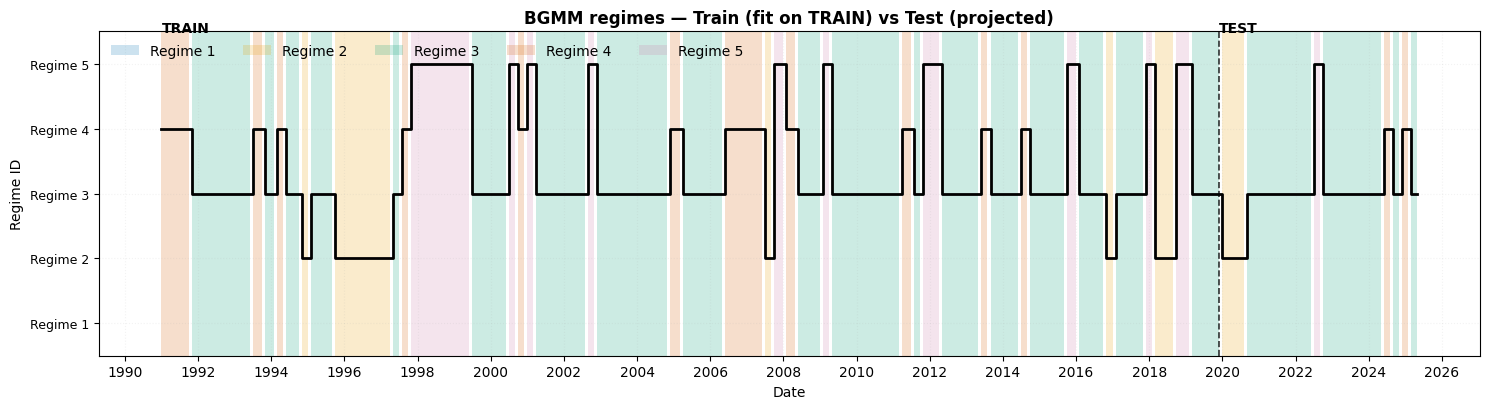

Active FULL-SAMPLE regimes: 5


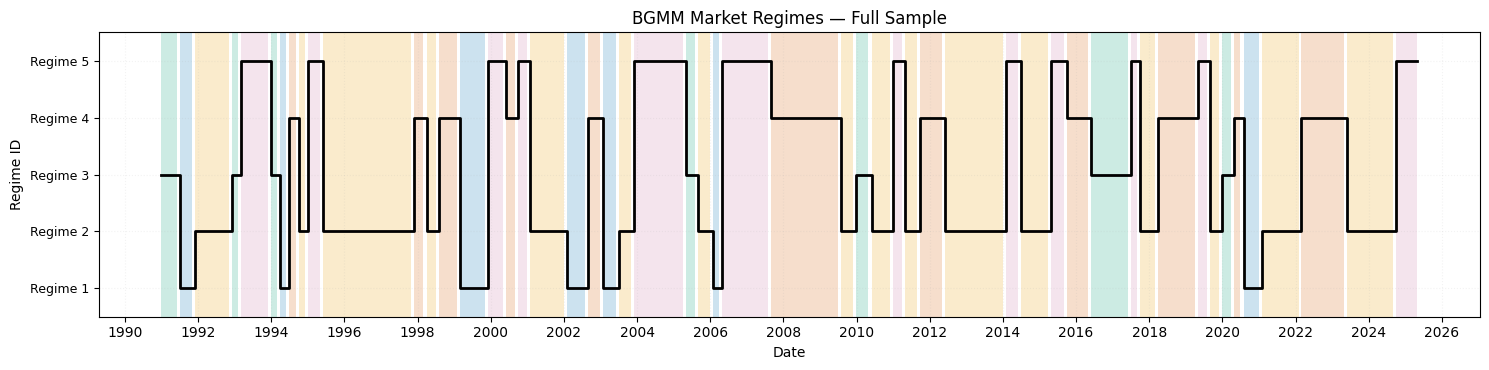


OOS diagnostics — LL gap: 12.32 | AMI: 0.068 | ARI: 0.020


In [4]:
# data scaling
# df_m, Z = combine_and_scale(FEATURES_XLSX, RETURNS_CSV, RETURN_COL, START_DATE, END_DATE)
df_m, Z = combine_and_scale_features_only(FEATURES_XLSX, START_DATE, END_DATE)

# TRAIN→TEST (train-only whitening) 
Z_tr = Z.loc[:TRAIN_END]
Z_te = Z.loc[TRAIN_END + MonthEnd(1):]  # strict split

# center & whiten using TRAIN only
mu_tr = Z_tr.mean()
Zc_tr = Z_tr - mu_tr
Zc    = Z - mu_tr
Winv_train = make_whitener(Zc_tr)
X      = pd.DataFrame(Zc.values @ Winv_train, index=Z.index, columns=Z.columns)
X_train = X.loc[:TRAIN_END]
X_test  = X.loc[TRAIN_END + MonthEnd(1):]

# fit on TRAIN, project both
bg_tr = make_bgmm().fit(X_train.values)
resp_tr = pd.DataFrame(bg_tr.predict_proba(X_train.values), index=X_train.index,
                       columns=[f"k{j}" for j in range(bg_tr.n_components)])
resp_te = pd.DataFrame(bg_tr.predict_proba(X_test.values),  index=X_test.index,
                       columns=resp_tr.columns)

reg_train = assign_with_persistence(resp_tr, bg_tr.weights_)
reg_test  = assign_with_persistence(resp_te, bg_tr.weights_)
print("Active TRAIN regimes:", int(reg_train[reg_train>=0].nunique()))
print("Active TEST regimes :", int(reg_test[reg_test>=0].nunique()))

# Plot TRAIN/TEST (two panels)
plot_train_test_merged(reg_train, reg_test, TRAIN_END,
                       title="BGMM regimes — Train (fit on TRAIN) vs Test (projected)")


# FULL-SAMPLE (full-sample whitening & fit)
mu_full = Z.mean()
Zc_full = Z - mu_full
Winv_full = make_whitener(Zc_full)
X_full = pd.DataFrame(Zc_full.values @ Winv_full, index=Z.index, columns=Z.columns)

bg_full = make_bgmm().fit(X_full.values)
resp_full = pd.DataFrame(bg_full.predict_proba(X_full.values), index=X_full.index,
                         columns=[f"k{j}" for j in range(bg_full.n_components)])
reg_full = assign_with_persistence(resp_full, bg_full.weights_)
print("Active FULL-SAMPLE regimes:", int(reg_full[reg_full>=0].nunique()))

# Plot FULL sample (one panel)
plot_full(reg_full)

# Optional OOS diagnostics (agreement)
if len(X_test) > 0:
    y_te_proj  = pd.Series(bg_tr.predict(X_test.values),  index=X_test.index)
    bg_te_ref  = make_bgmm().fit(X_test.values)
    y_te_refit = pd.Series(bg_te_ref.predict(X_test.values), index=X_test.index)
    ami = adjusted_mutual_info_score(y_te_proj, y_te_refit)
    ari = adjusted_rand_score(y_te_proj, y_te_refit)
    ll_train = bg_tr.score_samples(X_train.values).mean()
    ll_test  = bg_tr.score_samples(X_test.values).mean()
    print(f"\nOOS diagnostics — LL gap: {ll_train-ll_test:.2f} | AMI: {ami:.3f} | ARI: {ari:.3f}")

In [5]:
# Train Regime DataFrame
df_reg_train = pd.DataFrame({
    "Regime_ID": reg_train
})
df_reg_train.index.name = "Date"

# Test Regime DataFrame
df_reg_test = pd.DataFrame({
    "Regime_ID": reg_test
})
df_reg_test.index.name = "Date"


In [6]:
#df_reg_train
#df_reg_train.to_csv("BGMM_Regime_Train.csv")

In [7]:
#df_reg_test
#df_reg_test.to_csv("BGMM_Regime_Test.csv")

What BGMM is Doing

Model the whitened feature vector  $\mathbf{x}_t \in \mathbb{R}^p$ at each month $t$ as a mixture of $K$ Gaussian regimes:

$$
p(\mathbf{x}_t) = \sum_{k=1}^{K} \pi_k \, \mathcal{N}(\mathbf{x}_t \mid \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)
$$

where each component $k$ has mean $\boldsymbol{\mu}_k$, covariance $\boldsymbol{\Sigma}_k$, and mixture weight $\pi_k$ satisfying $\sum_{k=1}^{K} \pi_k = 1$.

A Dirichlet–process (DP) prior is placed on the mixture weights  $\pi = (\pi_1, \dots, \pi_K)$, which automatically downweights unused components so that the model can infer the effective number of active regimes without manually specifying the "true" $K$.

After fitting the model, we compute the responsibilities (posterior regime probabilities):

$$
r_{t,k} = p(z_t = k \mid \mathbf{x}_t)
$$

and then convert them into a stable regime time series using a persistence layer.


In [8]:
# ============================
# Post-hoc regime naming block
# ============================

# --- config ---
RETURNS_CSV = r"C:\Users\Lucas YY\capstone_vanguard\df_1M_ret.csv"
RETURN_COL  = "Russell 1000"   # <-- choose your benchmark for 'ret' statistics

# --- helpers ---
def load_monthly_returns(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date")
    else:
        df.index = pd.to_datetime(df.index)
    df = df.sort_index().resample("M").last()
    # drop junk & coerce numeric
    df = df.loc[:, [c for c in df.columns if not str(c).startswith("Unnamed")]]
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    # detect % vs decimal (simple heuristic)
    med_abs = df.abs().median(numeric_only=True)
    if (med_abs > 0.03).any():
        df = df / 100.0
    return df

def _first_in(df: pd.DataFrame, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _zscore(s: pd.Series) -> pd.Series:
    std = s.std(ddof=0)
    return (s - s.mean())/std if std > 0 else s*0

def _safe_mean(vals):
    arr = np.array([v for v in vals if pd.notna(v)], dtype=float)
    return float(arr.mean()) if arr.size else np.nan

# taxonomy (uses z-scored regime summaries)
def _classify_econ_regime(r: float, v: float, s: float, sl: float | None = None) -> str:
    # Crisis: negative returns + high stress/vol
    if (r < -0.3) and (s > 0.4 or v > 0.6):
        return "Crisis"
    # Walking on Ice: very strong returns, stress/vol not low
    if (r > 0.8) and (v > 0.0) and (s > 0.0):
        return "Walking on Ice"
    # Inflation: modest/ok returns, vol elevated, stress not very negative
    if (r > 0.0) and (v > 0.3) and (s > -0.2):
        return "Inflation"
    # Steady State: solid returns with calm vol & low stress
    if (r > 0.3) and (v < 0.0) and (s < 0.0):
        return "Steady State"
    # Correction: returns ≤ 0 with some vol, but not full stress spike
    if (r <= 0.0) and (v > 0.0) and (s <= 0.4):
        return "Correction"
    # Fallback
    return "Mid Expansion"

def merge_returns_into_dfm(df_m: pd.DataFrame,
                           returns_csv: str,
                           return_col: str) -> pd.DataFrame:
    """Join the chosen return column into df_m as 'ret' (month-end aligned)."""
    df_ret = load_monthly_returns(returns_csv)
    if return_col not in df_ret.columns:
        raise ValueError(f"'{return_col}' not in returns file. Found: {list(df_ret.columns)[:8]}...")
    return df_m.join(df_ret[[return_col]].rename(columns={return_col: "ret"}), how="left")

def summarize_and_name(df_m_ret: pd.DataFrame,
                       reg_series: pd.Series,
                       run_label: str) -> tuple[pd.DataFrame, pd.Series]:
    """
    For given run (train/test/full):
      - compute per-regime mean/std of 'ret' + mean stress proxies
      - z-score across regimes
      - classify to economic labels
      - return (summary_table, named_series)
    """
    # discover stress columns if present
    VIX_COL   = _first_in(df_m_ret, ["VIX","VIX Index","^VIX"])
    HY_COL    = _first_in(df_m_ret, ["US HY OAS","HY_OAS","BAMLH0A0HYM2"])
    MOVE_COL  = _first_in(df_m_ret, ["MOVE","ICE BofA MOVE Index"])
    SLOPE_COL = _first_in(df_m_ret, ["UST_10Y-2Y","slope_10y2y","10Y2Y"])

    # align, keep active regimes
    dfr = pd.concat({"regime_id": reg_series}, axis=1).join(df_m_ret, how="left")
    dfr = dfr[dfr["regime_id"] >= 0].copy()

    # aggregation spec
    agg = {"ret_mean": ("ret","mean"), "ret_vol": ("ret","std")}
    if VIX_COL:   agg["vix_lvl"] = (VIX_COL, "mean")
    if HY_COL:    agg["hy_oas"]  = (HY_COL,  "mean")
    if MOVE_COL:  agg["move"]    = (MOVE_COL,"mean")
    if SLOPE_COL: agg["slope"]   = (SLOPE_COL,"mean")

    # compute per-regime
    g = (dfr.groupby("regime_id")
            .agg(**{k: pd.NamedAgg(column=c, aggfunc=a) for k,(c,a) in agg.items()}))

    # z-score across regimes
    gz = g.apply(_zscore)

    # label
    labels = {}
    stress_vals = []
    for rid, row in gz.iterrows():
        r = float(row.get("ret_mean", np.nan))
        v = float(row.get("ret_vol",  np.nan))
        s = _safe_mean([row.get("vix_lvl", np.nan),
                        row.get("hy_oas",  np.nan),
                        row.get("move",    np.nan)])
        sl = row.get("slope", np.nan)
        s = float(s) if not np.isnan(s) else 0.0
        labels[rid] = _classify_econ_regime(r, v, s, None if pd.isna(sl) else float(sl))
        stress_vals.append(s)

    summary = gz.round(3)
    summary["stress"] = np.array(stress_vals).round(3)
    summary["economic_regime"] = pd.Series(labels)
    print(f"\n=== {run_label}: per-regime (z-scored) summary + economic labels ===")
    display(summary[ [c for c in ["ret_mean","ret_vol","vix_lvl","hy_oas","move","slope","stress","economic_regime"]
                       if c in summary.columns] ].sort_index())

    # map numeric IDs → names over time
    named = reg_series.map(summary["economic_regime"].to_dict())
    named.name = f"market_regime_{run_label.lower()}"
    return summary, named

# -------------------------
# RUN: merge + name regimes
# -------------------------
df_m_ret = merge_returns_into_dfm(df_m, RETURNS_CSV, RETURN_COL)

train_summary, reg_train_named = summarize_and_name(df_m_ret, reg_train, "TRAIN")
test_summary,  reg_test_named  = summarize_and_name(df_m_ret, reg_test,  "TEST")
full_summary,  reg_full_named  = summarize_and_name(df_m_ret, reg_full,  "FULL")

# quick counts
print("\nCounts — TRAIN:\n", reg_train_named.value_counts().sort_index())
print("\nCounts — TEST:\n",  reg_test_named.value_counts().sort_index())
print("\nCounts — FULL:\n",  reg_full_named.value_counts().sort_index())



=== TRAIN: per-regime (z-scored) summary + economic labels ===


C:\Users\Lucas YY\AppData\Local\Temp\ipykernel_25220\2066022264.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.sort_index().resample("M").last()


,ret_mean,ret_vol,vix_lvl,stress,economic_regime
regime_id,,,,,
1,0.509,-1.033,-0.775,-0.775,Steady State
2,-1.007,-0.052,-0.118,-0.118,Mid Expansion
3,-0.892,-0.540,-0.775,-0.775,Mid Expansion
4,1.390,1.624,1.669,1.669,Walking on Ice



=== TEST: per-regime (z-scored) summary + economic labels ===


,ret_mean,ret_vol,vix_lvl,stress,economic_regime
regime_id,,,,,
1,0.027,0.788,1.320,1.320,Inflation
2,0.097,-0.658,-0.372,-0.372,Mid Expansion
3,1.349,-1.277,-1.388,-1.388,Steady State
4,-1.473,1.147,0.439,0.439,Crisis



=== FULL: per-regime (z-scored) summary + economic labels ===


,ret_mean,ret_vol,vix_lvl,stress,economic_regime
regime_id,,,,,
0,-0.624,0.273,0.708,0.708,Crisis
1,1.354,-0.416,-0.424,-0.424,Steady State
2,0.949,-0.543,-0.765,-0.765,Steady State
3,-1.323,1.796,1.585,1.585,Crisis
4,-0.356,-1.110,-1.104,-1.104,Mid Expansion



Counts — TRAIN:
 market_regime_train
Mid Expansion     259
Steady State       35
Walking on Ice     54
Name: count, dtype: int64

Counts — TEST:
 market_regime_test
Crisis            3
Inflation         8
Mid Expansion    48
Steady State      6
Name: count, dtype: int64

Counts — FULL:
 market_regime_full
Crisis           131
Mid Expansion     87
Steady State     195
Name: count, dtype: int64


In [9]:
def regime_id_category_table(
    id_series: pd.Series,
    named_series: pd.Series,
    label: str | None = None,
    as_styler: bool = True,
):
    """
    Make a clean table mapping numeric regime IDs to their dominant Category,
    with counts and % of sample.

    Parameters
    ----------
    id_series     : pd.Series of ints (e.g., reg_train / reg_test / reg_full)
    named_series  : pd.Series of strings (e.g., reg_train_named)
    label         : optional title for the table (used in Styler caption)
    as_styler     : return a styled table (True) or plain DataFrame (False)
    """
    if id_series is None or named_series is None:
        raise ValueError("Both id_series and named_series are required.")

    # align and drop NAs / inactive
    df = pd.DataFrame({"regime_id": id_series, "category": named_series}).dropna()
    df = df[df["regime_id"] >= 0].copy()

    if df.empty:
        out = pd.DataFrame(columns=["Regime ID", "Category", "n_months", "pct_of_total"])
        return out.style.hide(axis="index") if as_styler else out

    # dominant category per regime id
    mode_cat = (
        df.groupby("regime_id")["category"]
          .agg(lambda s: s.value_counts().idxmax())
          .rename("Category")
    )
    n_months = df.groupby("regime_id").size().rename("n_months")
    pct      = (n_months / n_months.sum()).rename("pct_of_total")

    out = (
        pd.concat([mode_cat, n_months, pct], axis=1)
          .reset_index()
          .rename(columns={"regime_id": "Regime ID"})
          .sort_values("Regime ID")
    )

    if not as_styler:
        out["pct_of_total"] = (out["pct_of_total"] * 100).round(2)
        return out

    # nice formatting
    sty = (
        out.style.format({"pct_of_total": lambda x: f"{x*100:,.2f}%"} )
              .hide(axis="index")
              .set_table_styles([
                  {"selector": "th", "props": "text-align: left; font-weight: 600;"},
                  {"selector": "td", "props": "text-align: left;"},
              ])
              .set_properties(subset=["n_months"], **{"text-align": "right"})
              .set_caption(label or "")
    )
    return sty

train_tbl = regime_id_category_table(reg_train, reg_train_named, label="TRAIN")
test_tbl  = regime_id_category_table(reg_test,  reg_test_named,  label="TEST")
full_tbl  = regime_id_category_table(reg_full,  reg_full_named,  label="FULL")

display(train_tbl)
display(test_tbl)
display(full_tbl)

Regime ID,Category,n_months,pct_of_total
1,Steady State,35,10.06%
2,Mid Expansion,205,58.91%
3,Mid Expansion,54,15.52%
4,Walking on Ice,54,15.52%


Regime ID,Category,n_months,pct_of_total
1,Inflation,8,12.31%
2,Mid Expansion,48,73.85%
3,Steady State,6,9.23%
4,Crisis,3,4.62%


Regime ID,Category,n_months,pct_of_total
0,Crisis,38,9.20%
1,Steady State,157,38.01%
2,Steady State,38,9.20%
3,Crisis,93,22.52%
4,Mid Expansion,87,21.07%


In [10]:
df_m_ret

,IPNCONGD,INDPRO,IPNMAT,IPB51222S,IPFUELS,UEMPMEAN,USFIRE,UEMP27OV,UEMP15OV,CES0600000008,...,GDP_diff,CAPE,MOVE Index,VIX Index,USGG2YR Index,LUACOAS Index,.0210 F Index,SPX_realized_vol_20d,SPX_realized_vol_60d,ret
Date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,0.002740,-0.002251,0.002483,0.021674,0.001945,0.1,0.001514,0.018663,0.033250,-0.006152,...,0.0,-0.019834,104.63,19.52,0.3220,0.91,0.0780,0.111118,0.113308,-0.000279
1990-05-31,-0.004157,0.002950,-0.002815,0.008038,-0.027222,-0.1,0.000756,-0.007734,0.027949,0.005265,...,0.0,0.578500,94.70,17.37,-0.4620,0.87,0.1170,0.114950,0.113557,0.000891
1990-06-30,0.009733,0.003394,-0.004250,0.015360,0.031718,-0.1,0.001510,-0.006231,0.014732,-0.000012,...,-0.4,0.424669,96.98,15.50,-0.2620,0.88,0.1920,0.131966,0.119726,-0.000078
1990-07-31,-0.000826,-0.001665,0.005956,-0.005952,0.007012,0.3,0.000754,0.072321,0.066017,-0.000882,...,0.0,-0.069911,99.29,21.11,-0.3410,0.91,0.4620,0.130118,0.127704,-0.000111
1990-08-31,0.004811,0.003616,-0.000244,-0.008612,0.028187,0.3,0.000302,0.059256,0.046490,-0.003485,...,0.0,-1.578837,115.73,29.90,0.1840,0.94,0.7830,0.260971,0.185361,-0.000956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31,0.014579,0.010677,0.008263,0.105869,0.021976,0.1,0.001304,-0.064297,-0.046751,0.002206,...,0.0,0.360996,98.80,17.35,0.0907,0.80,0.3274,0.145731,0.127225,-0.000290
2025-01-31,0.004544,-0.001595,-0.020246,0.056349,-0.020472,-1.7,0.001520,-0.072176,-0.057457,0.001865,...,0.0,-0.581972,91.76,16.43,-0.0445,0.79,0.3416,0.140439,0.136536,0.000310
2025-02-28,0.003972,0.009577,0.006128,-0.007943,-0.018389,-0.7,0.001626,0.008282,-0.046374,-0.003781,...,0.0,0.057956,104.46,19.63,-0.2082,0.87,0.2193,0.129717,0.137508,-0.000186


In [11]:
# =========================
# Forward 12M table by regime
# =========================
import numpy as np
import pandas as pd
from scipy.stats import f_oneway

def _forward_12m(df_returns: pd.DataFrame) -> pd.DataFrame:
    """
    fwd_12(t) = Π_{i=t+1..t+12}(1+r_i) - 1
    Assumes monthly simple returns in decimal (e.g., 0.012 not 1.2% string).
    """
    cp = (1.0 + df_returns).cumprod()
    return (cp.shift(-12) / cp) - 1.0

def forward_table_by_regime(
    returns_wide: pd.DataFrame,      # monthly simple returns for many assets
    regime_ids: pd.Series,           # numeric regime ids aligned to dates (e.g., reg_train/reg_test/reg_full)
    regime_labels: dict | None = None,  # optional map {regime_id: "Label"}; if None uses id as label
    assets: list[str] = None,        # which columns to show; if None, show all present
    title: str = "Forward 12M Asset Returns by Market Regime",
) -> pd.DataFrame:
    """
    Produces a pretty table with rows = regimes (+ ANOVA row),
    columns = assets (mean ± std), plus two leading columns: Regime, Regime_Label.
    """
    # 1) restrict to requested assets
    if assets is None:
        assets = list(returns_wide.columns)
    assets = [c for c in assets if c in returns_wide.columns]
    if not assets:
        raise ValueError("None of the requested assets are in returns_wide.")

    # 2) compute 12M forward returns
    fwd12 = _forward_12m(returns_wide[assets])

    # 3) align with regimes and drop rows without regime
    df = fwd12.join(regime_ids.rename("regime"), how="left").dropna(subset=["regime"])
    df["regime"] = df["regime"].astype(int)

    # 4) mean/std per regime
    g = df.groupby("regime")[assets].agg(["mean", "std"])

    # 5) build display frame (mean ± std as text)
    regimes_sorted = sorted(g.index)
    disp = pd.DataFrame(index=regimes_sorted)

    for a in assets:
        m = g[(a, "mean")].reindex(regimes_sorted)
        s = g[(a, "std")].reindex(regimes_sorted)
        disp[a] = (m.round(3).astype(str) + " ± " + s.round(3).astype(str))

    # 6) add regime label column
    if regime_labels is None:
        regime_labels = {rid: str(rid) for rid in regimes_sorted}
    disp.insert(0, "Regime_Label", [regime_labels.get(rid, str(rid)) for rid in regimes_sorted])
    disp.insert(0, "Regime", regimes_sorted)

    # 7) ANOVA p-values by asset (across regimes)
    pvals = {}
    for a in assets:
        groups = [grp[a].dropna().values for _, grp in df.groupby("regime")]
        groups = [gvec for gvec in groups if len(gvec) > 1]
        if len(groups) >= 2:
            _, p = f_oneway(*groups)
            pvals[a] = p
        else:
            pvals[a] = np.nan

    # 8) append the ANOVA p-value row
    anova_row = {a: f"{pvals[a]:.4f}" if pd.notna(pvals[a]) else "" for a in assets}
    anova_row["Regime"] = ""
    anova_row["Regime_Label"] = "ANOVA p-value"
    disp = pd.concat([disp, pd.DataFrame([anova_row], columns=disp.columns)], ignore_index=True)

    # 9) nice title as pandas Styler caption (optional)
    try:
        return (disp.style
                    .hide(axis="index")
                    .set_caption(title)
                    .set_table_styles([
                        {"selector": "th", "props": "text-align:left; font-weight:600;"},
                        {"selector": "td", "props": "text-align:left;"},
                    ]))
    except Exception:
        # environments without Styler display: return the raw DataFrame
        return disp


In [12]:
RETURNS_CSV = r"C:\Users\Lucas YY\capstone_vanguard\df_1M_ret.csv"

def load_monthly_returns(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date")
    else:
        df.index = pd.to_datetime(df.index)
    df = df.sort_index().resample("M").last()
    # drop junk & coerce numeric
    df = df.loc[:, [c for c in df.columns if not str(c).startswith("Unnamed")]]
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    # if numbers are percentages, convert to decimals
    # if (df.abs().median(numeric_only=True) > 0.03).any():
    #     df = df / 100.0
    return df

df_ret_m = load_monthly_returns(RETURNS_CSV)

C:\Users\Lucas YY\AppData\Local\Temp\ipykernel_25220\1427009260.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.sort_index().resample("M").last()


In [13]:
df_ret_m

,Russell 1000,Russell 1000 Value,Russell 1000 Growth,MSCI World ex USA Index (DM ex-US Equities),MSCI EM Index (EM Equities),US Agg Bond,US Short-term Treasury,US Long-term Treasury,US IG Corporate Bond,US HY Corporate Bond,Global Agg ex-US Bond USD Hedged,Gold,Dollar
Date,,,,,,,,,,,,,
1990-02-28,0.011514,0.019618,0.004243,-0.068889,0.038369,0.003236,0.004505,-0.002920,0.002901,-0.020648,-0.012310,-0.017709,0.022299
1990-03-31,0.022369,0.007378,0.037740,-0.100762,-0.138884,0.000737,0.001987,-0.004133,0.000912,0.026236,-0.000818,-0.096149,0.012441
1990-04-30,-0.027945,-0.041467,-0.014519,-0.012665,0.064746,-0.009162,0.000080,-0.023881,-0.010425,-0.001691,0.000460,-0.002035,0.012608
1990-05-31,0.089062,0.076765,0.100899,0.110534,0.080414,0.029608,0.017873,0.046355,0.032347,0.019296,0.024813,-0.012780,-0.003310
1990-06-30,-0.007778,-0.025656,0.008843,-0.010192,0.033128,0.016045,0.011715,0.023010,0.017081,0.024167,0.005767,-0.029886,-0.009962
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,-0.006767,-0.031830,0.017406,0.041742,0.010387,0.003929,0.010136,-0.010883,-0.000327,-0.000203,0.014946,0.060014,-0.032633
2025-05-31,0.062435,0.032942,0.087779,0.041540,0.039988,-0.007159,-0.003813,-0.028712,-0.000113,0.016796,-0.000670,-0.007420,-0.006179
2025-06-30,0.049380,0.032301,0.063034,0.022235,0.056543,0.015375,0.007523,0.024993,0.018687,0.018392,0.004998,0.003021,-0.019829


In [14]:
# Choose assets to display (rename as needed to match your returns file)
ASSETS_ABS = [
    "Russell 1000",
    "US Agg Bond",
    "Gold",
    "Dollar",
]

# regime name maps for rows
train_label_map = {rid: nm for rid, nm in train_summary["economic_regime"].to_dict().items()}
test_label_map  = {rid: nm for rid, nm in test_summary["economic_regime"].to_dict().items()}
full_label_map  = {rid: nm for rid, nm in full_summary["economic_regime"].to_dict().items()}

tbl_train = forward_table_by_regime(
    returns_wide=df_ret_m,             # your monthly returns dataframe
    regime_ids=reg_train,              # numeric regimes on TRAIN window
    regime_labels=train_label_map,     # label per regime id
    assets=ASSETS_ABS,
    title="Forward 12M Asset Returns by Market Regime (Train Sample, with ANOVA significance)",
)

tbl_test = forward_table_by_regime(
    returns_wide=df_ret_m,
    regime_ids=reg_test,
    regime_labels=test_label_map,
    assets=ASSETS_ABS,
    title="Forward 12M Asset Returns by Market Regime (Test Sample, with ANOVA significance)",
)

tbl_full = forward_table_by_regime(
    returns_wide=df_ret_m,
    regime_ids=reg_full,
    regime_labels=full_label_map,
    assets=ASSETS_ABS,
    title="Forward 12M Asset Returns by Market Regime (Full Sample, with ANOVA significance)",
)

display(tbl_train)
display(tbl_test)
display(tbl_full)


Regime,Regime_Label,Russell 1000,US Agg Bond,Gold,Dollar
1,Steady State,0.193 ± 0.152,0.077 ± 0.04,-0.015 ± 0.159,0.046 ± 0.057
2,Mid Expansion,0.091 ± 0.137,0.056 ± 0.043,0.088 ± 0.16,0.019 ± 0.06
3,Mid Expansion,0.025 ± 0.163,0.067 ± 0.046,0.064 ± 0.156,0.03 ± 0.077
4,Walking on Ice,0.095 ± 0.197,0.05 ± 0.039,0.039 ± 0.107,0.012 ± 0.045
,ANOVA p-value,0.0000,0.0084,0.0015,0.0377


Regime,Regime_Label,Russell 1000,US Agg Bond,Gold,Dollar
1,Inflation,0.364 ± 0.136,0.016 ± 0.03,0.077 ± 0.1,-0.059 ± 0.025
2,Mid Expansion,0.117 ± 0.172,-0.014 ± 0.069,0.124 ± 0.158,0.03 ± 0.04
3,Steady State,0.138 ± 0.014,0.05 ± 0.014,0.389 ± 0.026,-0.016 ± 0.019
4,Crisis,0.14 ± 0.032,-0.018 ± 0.013,0.103 ± 0.044,-0.016 ± 0.012
,ANOVA p-value,0.0028,0.2540,0.0200,0.0000


Regime,Regime_Label,Russell 1000,US Agg Bond,Gold,Dollar
0,Crisis,0.124 ± 0.162,0.059 ± 0.048,0.049 ± 0.102,-0.012 ± 0.04
1,Steady State,0.118 ± 0.147,0.046 ± 0.058,0.044 ± 0.181,0.044 ± 0.055
2,Steady State,0.15 ± 0.103,0.041 ± 0.05,0.115 ± 0.17,-0.009 ± 0.051
3,Crisis,0.086 ± 0.217,0.048 ± 0.046,0.088 ± 0.12,0.012 ± 0.058
4,Mid Expansion,0.046 ± 0.123,0.059 ± 0.046,0.117 ± 0.147,0.017 ± 0.064
,ANOVA p-value,0.0033,0.2027,0.0033,0.0000


In [15]:
# ============================================================
# Forward 12M RELATIVE performance by market regime
# ============================================================

REL_PAIRS = [
    ("Russell 1000 Growth", "Russell 1000 Value"),
    ("US HY Corporate Bond", "US IG Corporate Bond"),
    ("US Long-term Treasury", "US Short-term Treasury"),
    ("MSCI EM Index (EM Equities)", "MSCI World ex USA Index (DM ex-US Equities)"),
]

def forward_relative_anova_table(
    returns_wide: pd.DataFrame,
    regime_ids: pd.Series,
    regime_labels: dict | None = None,
    rel_pairs: list[tuple[str,str]] = None,
    title: str = "Forward 12M Relative Performance by Market Regime",
):

    regime_ids = regime_ids.dropna()
    common_idx = returns_wide.index.intersection(regime_ids.index)
    if len(common_idx) == 0:
        raise ValueError("No overlapping dates between returns and regimes.")
    df = returns_wide.loc[common_idx]
    reg = regime_ids.loc[common_idx].astype(int)

    # --- Compute 12M forward returns ---
    fwd12 = _forward_12m(df)

    # --- Compute relative series (A–B) ---
    rel_data = {}

    def _make_rel_name(a, b):
        # Explicit mapping for clarity
        if "Russell 1000 Growth" in a and "Russell 1000 Value" in b:
            return "Growth – Value (12M fwd)"
        if "US HY Corporate Bond" in a and "US IG Corporate Bond" in b:
            return "HY – IG (12M fwd)"
        if "US Long-term Treasury" in a and "US Short-term Treasury" in b:
            return "Long – Short Treasury (12M fwd)"
        if "MSCI EM Index" in a and "MSCI World ex USA Index" in b:
            return "EM – DM Equities (12M fwd)"
        # Fallback: generic clean name
        return f"{a} – {b} (12M fwd)"
    for a, b in rel_pairs:
        if a not in fwd12.columns or b not in fwd12.columns:
            print(f"⚠️ Skipping missing pair: {a} vs {b}")
            continue
        rel_name = _make_rel_name(a, b)
        rel_data[rel_name] = fwd12[a] - fwd12[b]
    rel_df = pd.DataFrame(rel_data, index=fwd12.index).join(reg.rename("regime"))

    # --- Group summary (mean ± std) ---
    g = rel_df.groupby("regime").agg(["mean", "std"])
    regimes_sorted = sorted(g.index)
    disp = pd.DataFrame(index=regimes_sorted)
    for col in rel_data.keys():
        if (col, "mean") in g.columns:
            m = g[(col, "mean")].reindex(regimes_sorted)
            s = g[(col, "std")].reindex(regimes_sorted)
            disp[col] = (m.round(3).astype(str) + " ± " + s.round(3).astype(str))

    # --- Add regime label column ---
    label_map = regime_labels if regime_labels else {r: str(r) for r in regimes_sorted}
    disp.insert(0, "Regime_Label", [label_map.get(r, str(r)) for r in regimes_sorted])
    disp.insert(0, "Regime", regimes_sorted)

    # --- ANOVA p-values across regimes ---
    pvals = {}
    for col in rel_data.keys():
        groups = [grp[col].dropna().values for _, grp in rel_df.groupby("regime")]
        groups = [gvec for gvec in groups if len(gvec) > 1]
        if len(groups) >= 2:
            _, p = f_oneway(*groups)
            pvals[col] = p
        else:
            pvals[col] = np.nan

    # --- Append ANOVA row ---
    anova_row = {"Regime": "", "Regime_Label": "ANOVA p-value"}
    for col in rel_data.keys():
        anova_row[col] = f"{pvals[col]:.4f}" if not np.isnan(pvals[col]) else ""
    disp = pd.concat([disp, pd.DataFrame([anova_row])], ignore_index=True)

    # --- Style formatting ---
    return (
        disp.style
            .hide(axis="index")
            .set_caption(title)
            .set_table_styles([
                {"selector": "th", "props": "text-align:left; font-weight:600;"},
                {"selector": "td", "props": "text-align:left;"},
            ])
    )


In [16]:
rel_tbl_train = forward_relative_anova_table(
    returns_wide=df_ret_m,
    regime_ids=reg_train,
    regime_labels=train_label_map,
    rel_pairs=REL_PAIRS,
    title="Forward 12M Relative Performance by Market Regime (Train Sample)",
)

rel_tbl_test = forward_relative_anova_table(
    returns_wide=df_ret_m,
    regime_ids=reg_test,
    regime_labels=test_label_map,
    rel_pairs=REL_PAIRS,
    title="Forward 12M Relative Performance by Market Regime (Test Sample)",
)

rel_tbl_full = forward_relative_anova_table(
    returns_wide=df_ret_m,
    regime_ids=reg_full,
    regime_labels=full_label_map,
    rel_pairs=REL_PAIRS,
    title="Forward 12M Relative Performance by Market Regime (Full Sample)",
)

display(rel_tbl_train)
display(rel_tbl_test)
display(rel_tbl_full)


Regime,Regime_Label,Growth – Value (12M fwd),HY – IG (12M fwd),Long – Short Treasury (12M fwd),EM – DM Equities (12M fwd)
1,Steady State,0.047 ± 0.052,0.019 ± 0.039,0.05 ± 0.064,-0.049 ± 0.123
2,Mid Expansion,-0.006 ± 0.11,0.028 ± 0.078,0.042 ± 0.082,0.034 ± 0.145
3,Mid Expansion,0.04 ± 0.089,0.011 ± 0.096,0.042 ± 0.075,0.128 ± 0.237
4,Walking on Ice,0.049 ± 0.174,0.007 ± 0.117,0.011 ± 0.074,0.045 ± 0.216
,ANOVA p-value,0.0013,0.3142,0.0526,0.0000


Regime,Regime_Label,Growth – Value (12M fwd),HY – IG (12M fwd),Long – Short Treasury (12M fwd),EM – DM Equities (12M fwd)
1,Inflation,0.133 ± 0.154,0.085 ± 0.064,-0.072 ± 0.102,0.091 ± 0.084
2,Mid Expansion,0.055 ± 0.146,0.048 ± 0.021,-0.084 ± 0.079,-0.065 ± 0.057
3,Steady State,nan ± nan,nan ± nan,nan ± nan,nan ± nan
4,Crisis,0.139 ± 0.033,0.065 ± 0.009,-0.091 ± 0.023,-0.123 ± 0.046
,ANOVA p-value,0.2694,0.0094,0.9156,0.0000


Regime,Regime_Label,Growth – Value (12M fwd),HY – IG (12M fwd),Long – Short Treasury (12M fwd),EM – DM Equities (12M fwd)
0,Crisis,0.061 ± 0.137,0.033 ± 0.076,0.02 ± 0.06,0.047 ± 0.149
1,Steady State,0.014 ± 0.111,0.018 ± 0.054,0.024 ± 0.099,-0.042 ± 0.144
2,Steady State,0.076 ± 0.112,0.076 ± 0.073,0.002 ± 0.066,0.159 ± 0.188
3,Crisis,0.057 ± 0.141,0.034 ± 0.12,0.009 ± 0.093,0.031 ± 0.174
4,Mid Expansion,-0.001 ± 0.145,-0.011 ± 0.063,0.066 ± 0.093,0.1 ± 0.139
,ANOVA p-value,0.0014,0.0000,0.0002,0.0000


In [17]:
df_ret_m.head().describe()

,Russell 1000,Russell 1000 Value,Russell 1000 Growth,MSCI World ex USA Index (DM ex-US Equities),MSCI EM Index (EM Equities),US Agg Bond,US Short-term Treasury,US Long-term Treasury,US IG Corporate Bond,US HY Corporate Bond,Global Agg ex-US Bond USD Hedged,Gold,Dollar
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.017444,0.007328,0.027441,-0.016395,0.015555,0.008093,0.007232,0.007686,0.008563,0.009472,0.003583,-0.031712,0.006815
std,0.044398,0.045939,0.045130,0.080679,0.088469,0.015013,0.007407,0.027289,0.016503,0.020157,0.013576,0.037385,0.013124
min,-0.027945,-0.041467,-0.014519,-0.100762,-0.138884,-0.009162,0.000080,-0.023881,-0.010425,-0.020648,-0.012310,-0.096149,-0.009962
25%,-0.007778,-0.025656,0.004243,-0.068889,0.033128,0.000737,0.001987,-0.004133,0.000912,-0.001691,-0.000818,-0.029886,-0.003310
50%,0.011514,0.007378,0.008843,-0.012665,0.038369,0.003236,0.004505,-0.002920,0.002901,0.019296,0.000460,-0.017709,0.012441
75%,0.022369,0.019618,0.037740,-0.010192,0.064746,0.016045,0.011715,0.023010,0.017081,0.024167,0.005767,-0.012780,0.012608
max,0.089062,0.076765,0.100899,0.110534,0.080414,0.029608,0.017873,0.046355,0.032347,0.026236,0.024813,-0.002035,0.022299


______________________________

Regime-aware Black-Litterman Framework

In RABL, we model multiple market regimes \(k = 1, …, K\), each with distinct parameters.

At each time \(t\), we have posterior probabilities \( P_t = [p_{t,1}, …, p_{t,K}] \) from the regime model.

1. Compute per-regime equilibrium and BL posterior:

$$
\mu_{\text{eq},k} = λ\,\Sigma_k\,w_b
$$

$$
\mu_{\text{BL},k} =
\Big[(τ\Sigma_k)^{-1} + P^\top \Omega_k^{-1} P \Big]^{-1}
\Big[(τ\Sigma_k)^{-1}\mu_{\text{eq},k} + P^\top \Omega_k^{-1} q_k \Big]
$$

2. Combine them probabilistically using regime probabilities:

$$
\mu_t = \sum_{k=1}^{K} p_{t,k} \, \mu_{\text{BL},k}
$$

$$
\Sigma_t = \sum_{k=1}^{K} p_{t,k} \, \Sigma_k
$$

In [18]:
rty = pd.read_csv(r"C:\Users\Lucas YY\capstone_vanguard\Russel2000data.csv")
rty.columns = rty.columns.str.strip()        # clean header
rty['Date'] = pd.to_datetime(rty['Date'])    # ensure datetime
rty = rty.sort_values('Date')
rty = rty.set_index('Date').resample('M').last()
rty['Russell 2000'] = rty['RTY Index'].pct_change()
rty = rty[['Russell 2000']].dropna()

C:\Users\Lucas YY\AppData\Local\Temp\ipykernel_25220\2744544024.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rty = rty.set_index('Date').resample('M').last()


In [19]:
df_ret_m = df_ret_m.copy()
df_ret_m.index = pd.to_datetime(df_ret_m.index)
merged = df_ret_m.merge(rty, left_index=True, right_index=True, how='left')

In [20]:
merged

,Russell 1000,Russell 1000 Value,Russell 1000 Growth,MSCI World ex USA Index (DM ex-US Equities),MSCI EM Index (EM Equities),US Agg Bond,US Short-term Treasury,US Long-term Treasury,US IG Corporate Bond,US HY Corporate Bond,Global Agg ex-US Bond USD Hedged,Gold,Dollar,Russell 2000
Date,,,,,,,,,,,,,,
1990-02-28,0.011514,0.019618,0.004243,-0.068889,0.038369,0.003236,0.004505,-0.002920,0.002901,-0.020648,-0.012310,-0.017709,0.022299,0.029126
1990-03-31,0.022369,0.007378,0.037740,-0.100762,-0.138884,0.000737,0.001987,-0.004133,0.000912,0.026236,-0.000818,-0.096149,0.012441,0.037332
1990-04-30,-0.027945,-0.041467,-0.014519,-0.012665,0.064746,-0.009162,0.000080,-0.023881,-0.010425,-0.001691,0.000460,-0.002035,0.012608,-0.033802
1990-05-31,0.089062,0.076765,0.100899,0.110534,0.080414,0.029608,0.017873,0.046355,0.032347,0.019296,0.024813,-0.012780,-0.003310,0.068944
1990-06-30,-0.007778,-0.025656,0.008843,-0.010192,0.033128,0.016045,0.011715,0.023010,0.017081,0.024167,0.005767,-0.029886,-0.009962,0.000621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,-0.006767,-0.031830,0.017406,0.041742,0.010387,0.003929,0.010136,-0.010883,-0.000327,-0.000203,0.014946,0.060014,-0.032633,-0.023756
2025-05-31,0.062435,0.032942,0.087779,0.041540,0.039988,-0.007159,-0.003813,-0.028712,-0.000113,0.016796,-0.000670,-0.007420,-0.006179,0.052017
2025-06-30,0.049380,0.032301,0.063034,0.022235,0.056543,0.015375,0.007523,0.024993,0.018687,0.018392,0.004998,0.003021,-0.019829,0.052630


In [21]:
# wb
ASSETS = [
    "Russell 1000 Value",
    "Russell 1000 Growth",
    "Russell 2000",
    "US Short-term Treasury",
    "US Long-term Treasury",
    "US IG Corporate Bond",
    "US HY Corporate Bond",
]

bench_dict = {
    "Russell 1000 Value": 0.25,
    "Russell 1000 Growth": 0.25,
    "Russell 2000": 0.10,
    "US Short-term Treasury": 0.10,
    "US Long-term Treasury": 0.10,
    "US IG Corporate Bond": 0.15,
    "US HY Corporate Bond": 0.05,
}
w_bench = (
    pd.Series(bench_dict, name="Weight")
    .reindex(ASSETS)
    .fillna(0.0)
)
w_bench /= w_bench.sum()
w_bench

Russell 1000 Value        0.25
Russell 1000 Growth       0.25
Russell 2000              0.10
US Short-term Treasury    0.10
US Long-term Treasury     0.10
US IG Corporate Bond      0.15
US HY Corporate Bond      0.05
Name: Weight, dtype: float64

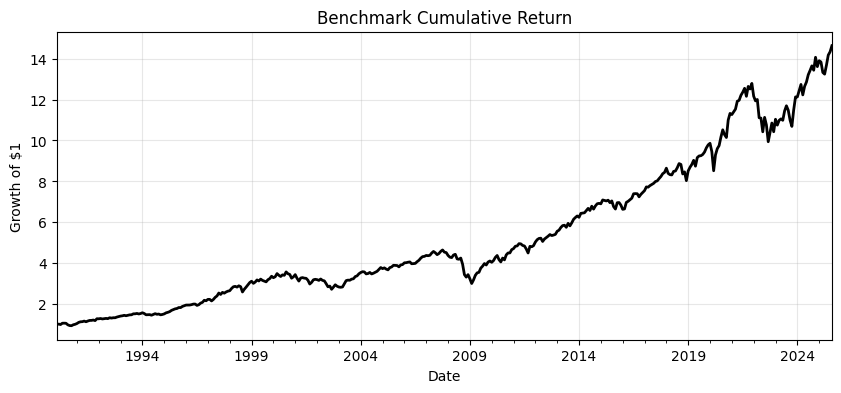

In [22]:
import matplotlib.pyplot as plt

bench_returns = (merged[ASSETS] * w_bench).sum(axis=1)
bench_returns.name = "Benchmark"
(1 + bench_returns).cumprod().plot(figsize=(10,4), lw=2, color='black', title="Benchmark Cumulative Return")
plt.ylabel("Growth of $1")
plt.grid(alpha=0.3)
plt.show()


In [23]:
R_train = merged.loc[:TRAIN_END, ASSETS].dropna(how="any")
labels  = reg_train_named.reindex(R_train.index)       # align index

def covs_by_label(R: pd.DataFrame, lbls: pd.Series, min_obs: int = 18):
    """Return dict[label]->(mu, Sigma, n) using Ledoit–Wolf shrinkage."""
    mu_dict, Sigma_dict, n_dict = {}, {}, {}
    for lab in sorted(lbls.dropna().unique()):
        mask = (lbls == lab)
        sub  = R.loc[mask]
        n    = len(sub)
        if n < min_obs:
            # fall back to global if too few obs
            sub = R
        mu = sub.mean()
        lw = LedoitWolf().fit(sub.values)
        Sigma = pd.DataFrame(lw.covariance_, index=R.columns, columns=R.columns)
        mu_dict[lab]    = mu
        Sigma_dict[lab] = Sigma
        n_dict[lab]     = n
    return mu_dict, Sigma_dict, n_dict

mu_lbl, Sigma_lbl, n_lbl = covs_by_label(R_train, labels)


In [24]:
labels.unique()

array([nan, 'Mid Expansion', 'Steady State', 'Walking on Ice'],
      dtype=object)

In [25]:
#Sigma_lbl.get("Crisis")
Sigma_lbl["Steady State"]

,Russell 1000 Value,Russell 1000 Growth,Russell 2000,US Short-term Treasury,US Long-term Treasury,US IG Corporate Bond,US HY Corporate Bond
Russell 1000 Value,0.000849,0.000690,0.000746,0.000035,0.000075,0.000132,0.000212
Russell 1000 Growth,0.000690,0.000998,0.000800,0.000052,0.000171,0.000140,0.000187
Russell 2000,0.000746,0.000800,0.001558,-0.000033,-0.000152,-0.000029,0.000160
US Short-term Treasury,0.000035,0.000052,-0.000033,0.000108,0.000110,0.000055,0.000016
US Long-term Treasury,0.000075,0.000171,-0.000152,0.000110,0.000645,0.000248,0.000056
US IG Corporate Bond,0.000132,0.000140,-0.000029,0.000055,0.000248,0.000216,0.000063
US HY Corporate Bond,0.000212,0.000187,0.000160,0.000016,0.000056,0.000063,0.000199


In [26]:
bench_ret = (R_train * w_bench.reindex(ASSETS)).sum(axis=1)
bench_ret.name = "Benchmark"

rf = 0.0                             
excess = bench_ret - rf
lam_hat = float(excess.mean() / (excess.var(ddof=1) + 1e-12))
lam = lam_hat  # risk-aversion coefficient
print(f"Estimated lambda (monthly units): {lam:.3f}")

mu_eq_lbl = {}
for label, S in Sigma_lbl.items():
    S = S.reindex(index=ASSETS, columns=ASSETS)          # enforce order
    mu_eq_lbl[label] = pd.Series(lam * (S.values @ w_bench.reindex(ASSETS).values),
                                 index=ASSETS, name=f"mu_eq[{label}]")
    
mu_eq_df = pd.DataFrame({k: v for k, v in mu_eq_lbl.items()})
print("\nEquilibrium priors (monthly):")
display(mu_eq_df.round(6))

# mu_eq_ann = (1.0 + mu_eq_df).pow(12) - 1.0
# print("Equilibrium priors (annualized approx):")
# display(mu_eq_ann.round(4))

Estimated lambda (monthly units): 9.380

Equilibrium priors (monthly):


,Mid Expansion,Steady State,Walking on Ice
Russell 1000 Value,0.007816,0.004698,0.015931
Russell 1000 Growth,0.009384,0.005202,0.017916
Russell 2000,0.009846,0.004948,0.019175
US Short-term Treasury,-0.000052,0.000461,0.000051
US Long-term Treasury,-0.000159,0.001520,-0.000027
US IG Corporate Bond,0.001688,0.001229,0.001324
US HY Corporate Bond,0.004161,0.001337,0.004019


In [27]:
import numpy as np
import pandas as pd

# ---------------- Utility: equilibrium (optional fallback) ---------------- #
def implied_equilibrium_returns(Sigma: pd.DataFrame,
                                w_bench: pd.Series,
                                lam_eq: float = 2.5) -> pd.Series:
    """mu_eq = lam * Sigma * w_bench (assets must be aligned)."""
    idx = w_bench.index
    S = Sigma.loc[idx, idx].values
    return pd.Series(lam_eq * (S @ w_bench.values), index=idx, name="mu_eq")

# ---------------- Utility: label normalization ---------------- #
def _norm_label(lbl: str) -> str:
    s = str(lbl).lower()
    if "walking" in s: return "walking on ice"
    if "mid"     in s: return "mid expansion"
    if "steady"  in s: return "steady"
    if "inflation" in s: return "inflation"
    if "crisis"    in s: return "crisis"
    if "recover"   in s: return "recovery"
    if "correct"   in s: return "correction"
    if "expansion" in s: return "expansion"
    return "neutral"

# ---------------- Black–Litterman posterior (single regime) ---------------- #
def bl_posterior(mu_eq: pd.Series,
                 Sigma: pd.DataFrame,
                 P: np.ndarray,
                 q: np.ndarray,
                 *,
                 tau: float = 0.05,
                 conf: float = 1.0) -> pd.Series:
    """
    mu_BL = [ (τΣ)^(-1) + P'Ω^(-1)P ]^(-1) [ (τΣ)^(-1) mu_eq + P'Ω^(-1) q ]
    with He–Litterman diagonal Ω scaled by confidence (larger 'conf' → smaller Ω).
    """
    # Align
    idx = mu_eq.index
    S = Sigma.loc[idx, idx].values
    mu0 = mu_eq.values

    # Shape checks
    n = len(idx)
    P = np.asarray(P, dtype=float)
    q = np.asarray(q, dtype=float).reshape(-1)
    assert P.shape[1] == n, f"P must be (m x {n}); got {P.shape}"
    assert P.shape[0] == q.shape[0], f"q length {q.shape[0]} must match P rows {P.shape[0]}"

    # He–Litterman Ω
    Sigma_tau = tau * S
    base_Omega = np.diag(np.diag(P @ Sigma_tau @ P.T))
    Omega = base_Omega / max(conf, 1e-6)

    A = np.linalg.inv(Sigma_tau) + P.T @ np.linalg.inv(Omega) @ P
    b = np.linalg.inv(Sigma_tau) @ mu0 + P.T @ np.linalg.inv(Omega) @ q
    mu_bl = np.linalg.solve(A, b)
    return pd.Series(mu_bl, index=idx, name="mu_bl")

# Assets (order must match your covariance/benchmark vectors)
ASSETS = [
    "Russell 1000 Value",
    "Russell 1000 Growth",
    "Russell 2000",
    "US Short-term Treasury",
    "US Long-term Treasury",
    "US IG Corporate Bond",
    "US HY Corporate Bond",
]

# 7-sleeve pick matrix (m x n) — tune/extend as needed
P_pick = np.array([
    [ 1,  -1,  0,  0,  0,  0,  0],        # Value - Growth
    [ 0,   0,  1, -1,  0,  0,  0],        # Small (R2K) - Bills (ST Tsy)
    [ 0,   0,  0, -1,  1,  0,  0],        # LT Tsy - ST Tsy
    [ 0,   0,  0,  0,  0, -1,  1],        # HY - IG
    [ 1/3, 1/3, 1/3, -1,  0,  0,  0],     # Equity basket - Bills
])

# Per-label monthly view vector q (length = rows of P_pick)
def q_for_label(lbl: str) -> np.ndarray:
    lbl = _norm_label(lbl)
    table = {
        "steady":         np.array([ +0.01/12, +0.01/12, -0.01/12,  0.00/12, +0.01/12 ]),
        "expansion":      np.array([ +0.02/12, +0.02/12, -0.01/12,  0.00/12, +0.03/12 ]),
        "mid expansion":  np.array([ +0.01/12, +0.01/12, -0.01/12,  0.00/12, +0.01/12 ]),
        "inflation":      np.array([ +0.01/12, -0.01/12, -0.03/12,  0.00/12, +0.01/12 ]),
        "crisis":         np.array([ -0.03/12, -0.03/12, +0.03/12, +0.04/12, -0.05/12 ]),
        "walking on ice": np.array([  0.00/12, +0.02/12, +0.02/12,  0.00/12, -0.01/12 ]),
        "correction":     np.array([ -0.01/12,  0.00/12,  0.00/12, +0.01/12, -0.02/12 ]),
        "recovery":       np.array([ +0.01/12, +0.02/12, -0.01/12,  0.00/12, +0.02/12 ]),
        "neutral":        np.zeros(P_pick.shape[0]),
    }
    return table.get(lbl, table["neutral"])

# Confidence per label (>1 = stronger views, <1 = weaker)
CONF = {
    "steady": 1.10, "expansion": 1.10, "mid expansion": 1.00,
    "inflation": 0.95, "crisis": 1.30, "walking on ice": 1.15,
    "correction": 0.95, "recovery": 1.15, "neutral": 1.00
}
def conf_for_label(lbl: str) -> float:
    return CONF.get(_norm_label(lbl), 1.0)

# ======================= Main: compute mu_BL per label ======================= #
def compute_mu_bl_by_label(Sigma_lbl: dict[str, pd.DataFrame],
                           mu_eq_lbl: dict[str, pd.Series] | None,
                           *,
                           w_bench: pd.Series | None = None,
                           lam_eq: float = 2.5,
                           tau: float = 0.05) -> dict[str, pd.Series]:
    """
    Inputs
    ------
    Sigma_lbl : dict[label] -> covariance (DataFrame, index/cols = ASSETS)
    mu_eq_lbl : dict[label] -> equilibrium mu (Series on ASSETS). If None, will compute
                using w_bench and lam_eq (requires w_bench).
    w_bench   : Series of benchmark weights on ASSETS (needed only if mu_eq_lbl is None)
    """
    # Align assets and optionally build mu_eq per label
    labels = list(Sigma_lbl.keys())
    mu_eq_lbl = {} if mu_eq_lbl is None else dict(mu_eq_lbl)

    for lab in labels:
        S = Sigma_lbl[lab].reindex(index=ASSETS, columns=ASSETS)
        Sigma_lbl[lab] = S
        if lab not in mu_eq_lbl:
            if w_bench is None:
                raise ValueError("mu_eq_lbl is None and w_bench not provided.")
            mu_eq_lbl[lab] = implied_equilibrium_returns(S, w_bench.reindex(ASSETS).fillna(0.0), lam_eq)

        # Ensure mu_eq aligned and 1–1 with ASSETS
        mu_eq_lbl[lab] = mu_eq_lbl[lab].reindex(ASSETS)

    assert P_pick.shape[1] == len(ASSETS), \
        f"P_pick second dimension must equal number of assets ({len(ASSETS)}); got {P_pick.shape}"

    mu_bl_lbl = {}
    for lab in labels:
        q = q_for_label(lab)
        c = conf_for_label(lab)
        mu_bl_lbl[lab] = bl_posterior(
            mu_eq=mu_eq_lbl[lab],
            Sigma=Sigma_lbl[lab],
            P=P_pick,
            q=q,
            tau=tau,
            conf=c,
        )
    return mu_bl_lbl

mu_bl_lbl = compute_mu_bl_by_label(Sigma_lbl, mu_eq_lbl, w_bench=w_bench, lam_eq=2.5, tau=0.05)
mu_bl_df = pd.DataFrame(mu_bl_lbl)  # columns = labels
display(mu_bl_df.round(6))


,Mid Expansion,Steady State,Walking on Ice
Russell 1000 Value,0.004273,0.003234,0.006134
Russell 1000 Growth,0.004182,0.002922,0.006579
Russell 2000,0.003659,0.002439,0.006538
US Short-term Treasury,0.000341,0.000668,0.000702
US Long-term Treasury,0.000405,0.000724,0.001674
US IG Corporate Bond,0.001237,0.000890,0.001042
US HY Corporate Bond,0.001818,0.000922,0.001262


In [28]:
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment

def _parse_id(col):
    try:
        return int(str(col).lstrip('k'))
    except Exception:
        return None

labels_used = sorted(Sigma_lbl.keys())

# initialize P_lbl using TRAIN-known labels
P_lbl = pd.DataFrame(0.0, index=reg_test_named.index, columns=labels_used)

# map any unseen labels in TEST to a fallback (e.g. Mid Expansion)
lab_series = reg_test_named.reindex(P_lbl.index).fillna("neutral")
lab_series = lab_series.where(lab_series.isin(labels_used), "Mid Expansion")

# fill one-hot probabilities
ix = P_lbl.columns.get_indexer(lab_series.values)
valid = ix >= 0
rows = np.arange(len(P_lbl))
P_lbl.values[rows[valid], ix[valid]] = 1.0

P_lbl = P_lbl.rolling(3, min_periods=1).mean()

P_lbl

,Mid Expansion,Steady State,Walking on Ice
Date,,,
2019-12-31,1.000000,0.000000,0.0
2020-01-31,1.000000,0.000000,0.0
2020-02-29,1.000000,0.000000,0.0
2020-03-31,1.000000,0.000000,0.0
2020-04-30,1.000000,0.000000,0.0
...,...,...,...
2024-12-31,0.333333,0.666667,0.0
2025-01-31,0.000000,1.000000,0.0
2025-02-28,0.333333,0.666667,0.0


In [29]:
import numpy as np
import pandas as pd

# Basic checks
assert isinstance(merged, pd.DataFrame) and len(ASSETS) > 0, "Provide merged returns and ASSETS."
assert isinstance(w_bench, pd.Series) and set(w_bench.index) == set(ASSETS), "w_bench must align with ASSETS."
assert isinstance(P_lbl, pd.DataFrame) and len(P_lbl) > 0, "Provide label probabilities P_lbl."
assert isinstance(mu_bl_lbl, dict) and isinstance(Sigma_lbl, dict), "Provide mu_bl_lbl and Sigma_lbl dicts."

# Build R_test from merged & TRAIN_END
R_test = merged.loc[TRAIN_END:, ASSETS].dropna(how="any").copy()


# Helper utilities (indexing & coercion)
def to_me_index(idx):
    """Coerce any index-like to tz-naive month-end timestamps."""
    dt = pd.to_datetime(idx)
    return dt.to_series().dt.to_period("M").dt.to_timestamp("M").index

def _ensure_sigma_df(v, assets):
    """
    Coerce any covariance object to an n×n DataFrame over `assets`.
    Supported:
      - DataFrame (will be reindexed)
      - ndarray (n×n)
      - Series with MultiIndex (unstack to DataFrame)
      - Series of length n (treated as diagonal variances)
    """
    if isinstance(v, pd.DataFrame):
        return v.reindex(index=assets, columns=assets)
    if isinstance(v, np.ndarray):
        if v.ndim == 2 and v.shape[0] == v.shape[1] == len(assets):
            return pd.DataFrame(v, index=assets, columns=assets)
        raise TypeError(f"ndarray Sigma has shape {v.shape}, expected ({len(assets)},{len(assets)})")
    if isinstance(v, pd.Series):
        if isinstance(v.index, pd.MultiIndex):
            df = v.unstack()
            return df.reindex(index=assets, columns=assets)
        if len(v) == len(assets):
            # treat as diagonal
            return pd.DataFrame(np.diag(v.values), index=assets, columns=assets)
        raise TypeError("Series Sigma unsupported (needs MultiIndex to unstack or length==n for diagonal).")
    raise TypeError(f"Unsupported Sigma type: {type(v)}")

# Blend label-level (mu, Sigma) into time-varying paths
def blend_label_params(P_lbl: pd.DataFrame,
                       mu_bl_lbl: dict,
                       Sigma_lbl: dict,
                       assets: list[str]) -> tuple[pd.DataFrame, dict]:
    """
    Returns:
      - mu_t: DataFrame (T×n) blended expected returns
      - Sigma_t_dict: dict[Timestamp] -> DataFrame (n×n) blended covariance
    Only labels present in both mu_bl_lbl and Sigma_lbl and in P_lbl.columns are used.
    """
    labels = [c for c in P_lbl.columns if (c in mu_bl_lbl) and (c in Sigma_lbl)]
    if len(labels) == 0:
        raise ValueError("No overlapping labels between P_lbl and mu_bl_lbl/Sigma_lbl.")

    # stack for fast linear combos
    mu_stack = np.stack([mu_bl_lbl[l].reindex(assets).values for l in labels], axis=1)  # n × L
    Sig_stack = np.stack([Sigma_lbl[l].reindex(index=assets, columns=assets).values for l in labels], axis=2)  # n × n × L

    mu_t = pd.DataFrame(index=P_lbl.index, columns=assets, dtype=float)
    Sigma_t_dict = {}

    for t, p in P_lbl[labels].iterrows():
        w = p.values.reshape(-1, 1)                 # L × 1
        mu_t.loc[t] = (mu_stack @ w).ravel()        # n
        S = np.zeros((len(assets), len(assets)))
        for j in range(len(labels)):
            S += float(w[j]) * Sig_stack[:, :, j]
        Sigma_t_dict[t] = pd.DataFrame(S, index=assets, columns=assets)

    return mu_t, Sigma_t_dict

mu_t, Sigma_t = blend_label_params(P_lbl, mu_bl_lbl, Sigma_lbl, ASSETS)

# Normalize all indices to month-end & build timeline
R_test.index = to_me_index(R_test.index)
mu_t.index   = to_me_index(mu_t.index)
P_lbl.index  = to_me_index(P_lbl.index)

def _to_me(ts):
    return pd.Timestamp(ts).to_period("M").to_timestamp("M")

Sigma_raw = {}
for k, v in Sigma_t.items():
    k_me = _to_me(k)
    Sigma_raw[k_me] = _ensure_sigma_df(v, R_test.columns)

available_keys = sorted(Sigma_raw.keys())
timeline = R_test.index.intersection(mu_t.index).intersection(P_lbl.index)
common_idx = timeline.sort_values()

# Forward-fill Sigma across time WITHOUT collapsing matrices
Sigma_t_ff = {}
last_S = None
it = iter(available_keys)
next_key = next(it, None)

for t in common_idx:
    if t in Sigma_raw:
        last_S = Sigma_raw[t]
    else:
        while next_key is not None and next_key <= t:
            last_S = Sigma_raw[next_key]
            next_key = next(it, None)
        if last_S is None and available_keys:
            last_S = Sigma_raw[available_keys[0]]
    last_S = last_S.reindex(index=R_test.columns, columns=R_test.columns)
    Sigma_t_ff[t] = last_S.copy()

# Replace with forward-filled dict
Sigma_t = Sigma_t_ff

# Truncate all inputs to the common index
R_test = R_test.loc[common_idx]
mu_t   = mu_t.loc[common_idx]
P_lbl  = P_lbl.loc[common_idx]


# Simple benchmark-relative allocator (LO)
def solve_bench_relative(mu: pd.Series,
                         Sigma: pd.DataFrame,
                         w_bench: pd.Series,
                         risk_aversion: float = 5.0,
                         delta: float = 0.10) -> pd.Series:
    """
    Closed-form fallback: project benchmark toward mu direction within ±delta per asset.
    Long-only, benchmark-relative deviation caps.
    """
    idx = w_bench.index
    # safety reindex
    if not isinstance(Sigma, pd.DataFrame):
        Sigma = pd.DataFrame(Sigma, index=idx, columns=idx)
    else:
        Sigma = Sigma.reindex(index=idx, columns=idx)
    mu = mu.reindex(idx)

    # benchmark-implied returns (relative taste)
    S = Sigma.values
    mu_b = risk_aversion * (S @ w_bench.values)
    mu_rel = pd.Series(mu.values - mu_b, index=idx)

    # proportional tilt toward positive mu_rel; clip to ±delta; renormalize
    tilt = mu_rel.clip(lower=0)
    if tilt.sum() > 0:
        tilt = tilt / tilt.sum()
        w_target = (w_bench + delta * (tilt - 1/len(idx))).clip(lower=w_bench - delta, upper=w_bench + delta)
        w = w_target.clip(lower=0)
        return w / w.sum()
    return w_bench.copy()

# Roll forward weights & compute NAV
def run_rabl_backtest_safe(R_test: pd.DataFrame,
                           mu_t: pd.DataFrame,
                           Sigma_t: dict,
                           w_bench: pd.Series,
                           delta: float = 0.10,
                           risk_aversion: float = 5.0,
                           tc_bps: float = 0.0):
    assets = w_bench.index
    assert list(R_test.columns) == list(assets), "Asset order mismatch between R_test and w_bench."
    assert set(mu_t.columns) >= set(assets), "mu_t missing assets."
    assert all(isinstance(Sigma_t[t], pd.DataFrame) for t in Sigma_t), "Sigma_t values must be DataFrames."

    W   = pd.DataFrame(index=R_test.index, columns=assets, dtype=float)
    NAV = pd.Series(index=R_test.index, dtype=float)

    w_prev = None
    for i, t in enumerate(R_test.index):
        S_t = Sigma_t[t]  # exists for every t in common_idx
        w   = solve_bench_relative(mu_t.loc[t], S_t, w_bench, risk_aversion, delta)
        W.loc[t] = w

        r  = float((w * R_test.loc[t, assets]).sum())
        tc = 0.0
        if (w_prev is not None) and (tc_bps > 0):
            tc = (tc_bps / 1e4) * float((w - w_prev).abs().sum())
        NAV.iloc[i] = (1.0 if i == 0 else NAV.iloc[i-1]) * (1.0 + r - tc)
        w_prev = w

    # performance summary
    port_ret = (W.shift(1).fillna(W.iloc[0]) * R_test[assets]).sum(axis=1)
    ann = 12
    er  = port_ret.mean() * ann
    vol = port_ret.std(ddof=1) * np.sqrt(ann)
    sharpe0 = er / (vol + 1e-12)
    mdd = (NAV / NAV.cummax()).min() - 1
    summary = {
        "AnnReturn": float(er),
        "AnnVol": float(vol),
        "Sharpe(0%)": float(sharpe0),
        "MaxDD": float(mdd)
    }
    return W, NAV, summary


W, nav, summary = run_rabl_backtest_safe(
    R_test=R_test,
    mu_t=mu_t,
    Sigma_t=Sigma_t,
    w_bench=w_bench,
    delta=0.10,
    risk_aversion=5.0,
    tc_bps=0.0
)

print("Backtest summary:", summary)
print("Weights head:\n", W.head())
print("NAV tail:\n", nav.tail())


Backtest summary: {'AnnReturn': 0.06227278893368897, 'AnnVol': 0.12803090817513077, 'Sharpe(0%)': 0.4863887152000902, 'MaxDD': -0.2212418686209523}
Weights head:
             Russell 1000 Value  Russell 1000 Growth  Russell 2000  \
Date                                                                
2019-12-31            0.243925             0.235714      0.085714   
2020-01-31            0.243925             0.235714      0.085714   
2020-02-29            0.243925             0.235714      0.085714   
2020-03-31            0.243925             0.235714      0.085714   
2020-04-30            0.243925             0.235714      0.085714   

            US Short-term Treasury  US Long-term Treasury  \
Date                                                        
2019-12-31                0.114041               0.123303   
2020-01-31                0.114041               0.123303   
2020-02-29                0.114041               0.123303   
2020-03-31                0.114041              

C:\Users\Lucas YY\AppData\Local\Temp\ipykernel_25220\1227632000.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S += float(w[j]) * Sig_stack[:, :, j]


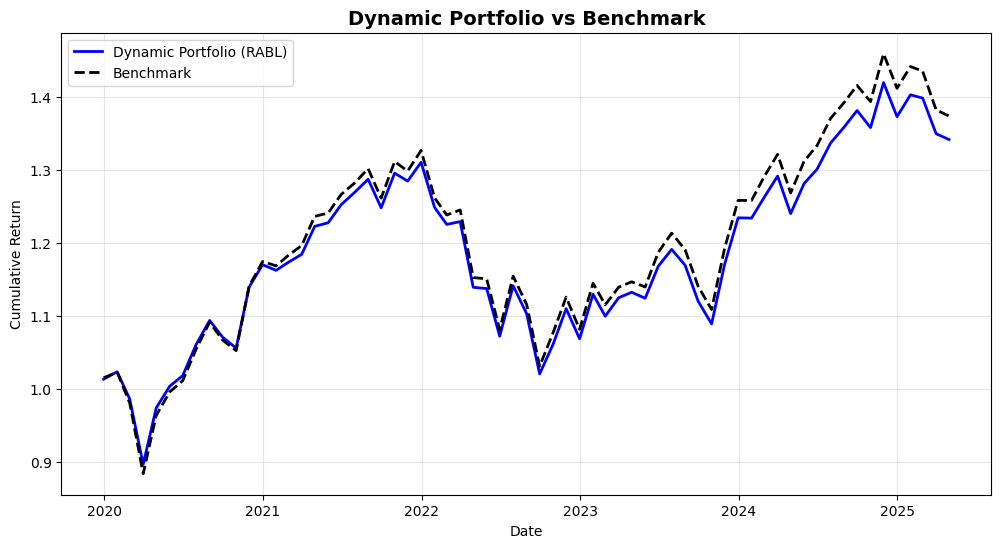

In [30]:
import matplotlib.pyplot as plt

# Compute benchmark cumulative returns
bench_returns = (R_test * w_bench).sum(axis=1)
bench_cum_returns = (1 + bench_returns).cumprod()

# Plot NAV (dynamic portfolio) vs benchmark
plt.figure(figsize=(12, 6))
plt.plot(nav, label="Dynamic Portfolio (RABL)", color="blue", lw=2)
plt.plot(bench_cum_returns, label="Benchmark", color="black", lw=2, linestyle="--")
plt.title("Dynamic Portfolio vs Benchmark", fontsize=14, fontweight="bold")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

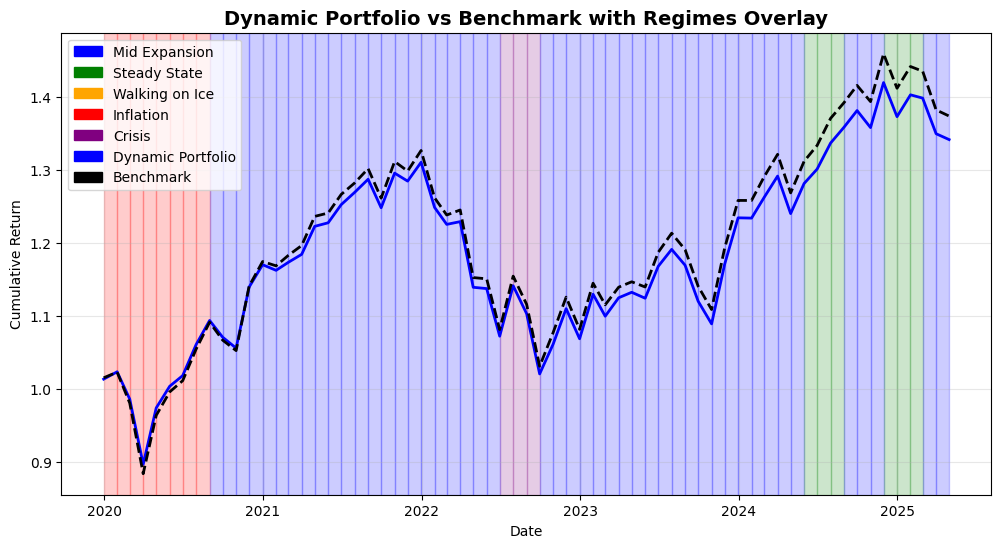

In [31]:
from matplotlib.patches import Patch

import matplotlib.pyplot as plt

# Define a color map for the regimes
regime_colors = {
    "Mid Expansion": "blue",
    "Steady State": "green",
    "Walking on Ice": "orange",
    "Inflation": "red",
    "Crisis": "purple",
}

# Create a legend for the regimes
legend_patches = [Patch(color=color, label=label) for label, color in regime_colors.items()]

# Plot the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(nav, label="Dynamic Portfolio (RABL)", color="blue", lw=2)
plt.plot(bench_cum_returns, label="Benchmark", color="black", lw=2, linestyle="--")

# Overlay the regimes
for start_date, end_date in zip(reg_test_named.index[:-1], reg_test_named.index[1:]):
    regime = reg_test_named.loc[start_date]
    plt.axvspan(start_date, end_date, color=regime_colors.get(regime, "gray"), alpha=0.2)

# Add title, labels, legend, and grid
plt.title("Dynamic Portfolio vs Benchmark with Regimes Overlay", fontsize=14, fontweight="bold")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.legend(handles=legend_patches + [Patch(color="blue", label="Dynamic Portfolio"), Patch(color="black", label="Benchmark")])
plt.grid(alpha=0.3)
plt.show()

C:\Users\Lucas YY\AppData\Local\Temp\ipykernel_25220\626260783.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  rolling_data = pd.concat([rolling_data, R_test.loc[[t]]]).tail(12)  # Keep up to 12 months of data
C:\Users\Lucas YY\AppData\Local\Temp\ipykernel_25220\626260783.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rolling_data = pd.concat([rolling_data, R_test.loc[[t]]]).tail(12)  # Keep up to 12 months of data
c:\Users\Lucas YY\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\frame.py:112

Monthly Rebalancing Backtest Summary: {'AnnReturn': 0.0662188214576295, 'AnnVol': 0.13106128383865273, 'Sharpe(0%)': 0.5052508224980086, 'MaxDD': -0.22081889246700537}


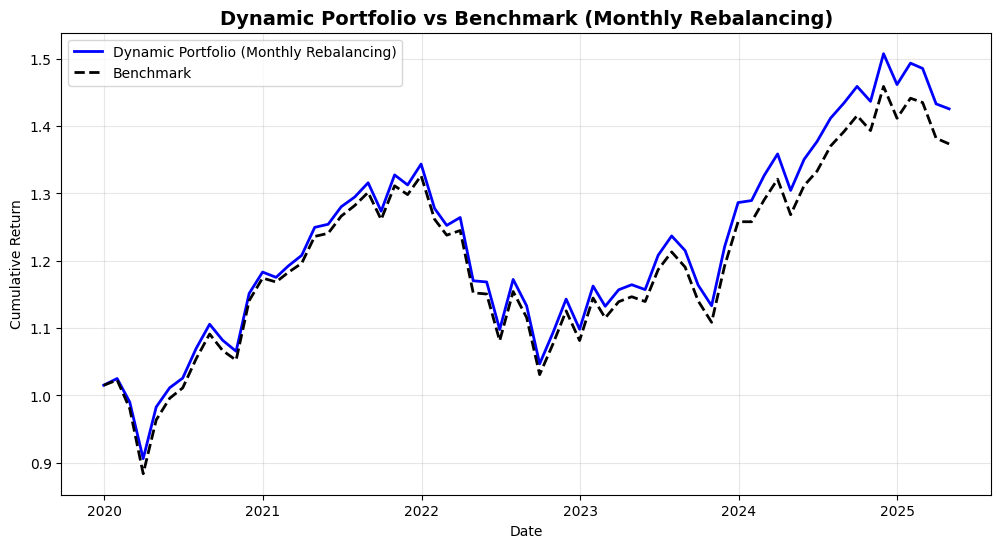

In [33]:
def run_rabl_backtest_monthly(
    R_test: pd.DataFrame,
    mu_t: pd.DataFrame,
    Sigma_t: dict,
    w_bench: pd.Series,
    delta: float = 0.10,
    risk_aversion: float = 5.0,
    tc_bps: float = 0.0,
):
    """
    Backtest with monthly rebalancing and dynamic MVO updates.
    """
    assets = w_bench.index
    assert list(R_test.columns) == list(assets), "Asset order mismatch between R_test and w_bench."
    assert set(mu_t.columns) >= set(assets), "mu_t missing assets."
    assert all(isinstance(Sigma_t[t], pd.DataFrame) for t in Sigma_t), "Sigma_t values must be DataFrames."

    W = pd.DataFrame(index=R_test.index, columns=assets, dtype=float)
    NAV = pd.Series(index=R_test.index, dtype=float)

    w_prev = None
    rolling_data = pd.DataFrame(columns=assets)  # Rolling window data for dynamic updates

    for i, t in enumerate(R_test.index):
        # Add the past month's data to the rolling window
        rolling_data = pd.concat([rolling_data, R_test.loc[[t]]]).tail(12)  # Keep up to 12 months of data

        # Update covariance matrix and expected returns dynamically
        mu_dynamic = rolling_data.mean()
        Sigma_dynamic = rolling_data.cov()

        # Solve for optimal weights
        w = solve_bench_relative(mu_dynamic, Sigma_dynamic, w_bench, risk_aversion, delta)
        W.loc[t] = w

        # Compute portfolio return and transaction costs
        r = float((w * R_test.loc[t, assets]).sum())
        tc = 0.0
        if (w_prev is not None) and (tc_bps > 0):
            tc = (tc_bps / 1e4) * float((w - w_prev).abs().sum())
        NAV.iloc[i] = (1.0 if i == 0 else NAV.iloc[i - 1]) * (1.0 + r - tc)
        w_prev = w

    # Performance summary
    port_ret = (W.shift(1).fillna(W.iloc[0]) * R_test[assets]).sum(axis=1)
    ann = 12
    er = port_ret.mean() * ann
    vol = port_ret.std(ddof=1) * np.sqrt(ann)
    sharpe0 = er / (vol + 1e-12)
    mdd = (NAV / NAV.cummax()).min() - 1
    summary = {
        "AnnReturn": float(er),
        "AnnVol": float(vol),
        "Sharpe(0%)": float(sharpe0),
        "MaxDD": float(mdd),
    }
    return W, NAV, summary


# Run the backtest with monthly rebalancing
W_monthly, nav_monthly, summary_monthly = run_rabl_backtest_monthly(
    R_test=R_test,
    mu_t=mu_t,
    Sigma_t=Sigma_t,
    w_bench=w_bench,
    delta=0.10,
    risk_aversion=5.0,
    tc_bps=0.0,
)

print("Monthly Rebalancing Backtest Summary:", summary_monthly)

# Plot NAV (dynamic portfolio) vs benchmark
bench_returns = (R_test * w_bench).sum(axis=1)
bench_cum_returns = (1 + bench_returns).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(nav_monthly, label="Dynamic Portfolio (Monthly Rebalancing)", color="blue", lw=2)
plt.plot(bench_cum_returns, label="Benchmark", color="black", lw=2, linestyle="--")
plt.title("Dynamic Portfolio vs Benchmark (Monthly Rebalancing)", fontsize=14, fontweight="bold")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

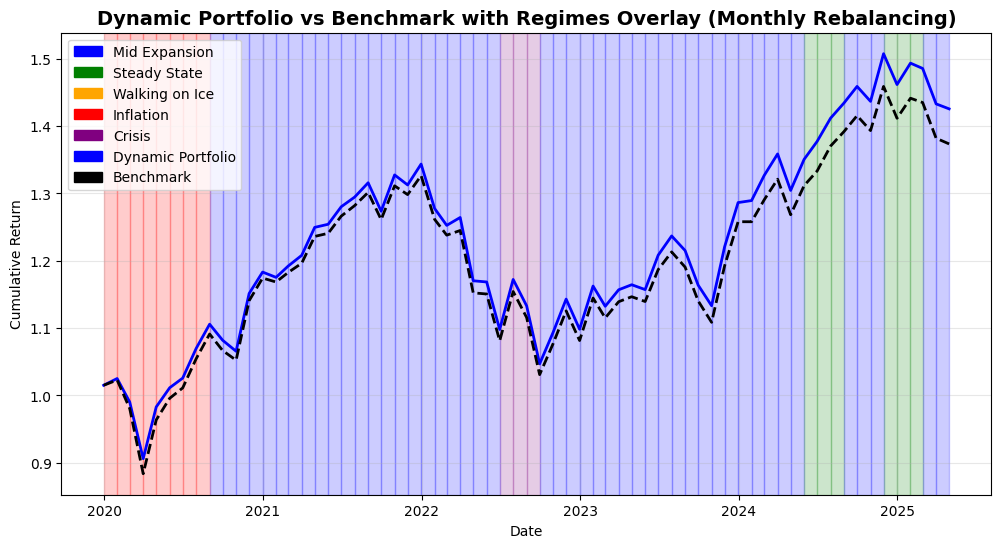

In [34]:
# Overlay regimes on the cumulative return graph
plt.figure(figsize=(12, 6))

# Plot NAV (dynamic portfolio) vs benchmark
plt.plot(nav_monthly, label="Dynamic Portfolio (Monthly Rebalancing)", color="blue", lw=2)
plt.plot(bench_cum_returns, label="Benchmark", color="black", lw=2, linestyle="--")

# Overlay the regimes
for start_date, end_date in zip(reg_test_named.index[:-1], reg_test_named.index[1:]):
    regime = reg_test_named.loc[start_date]
    plt.axvspan(start_date, end_date, color=regime_colors.get(regime, "gray"), alpha=0.2)

# Add title, labels, legend, and grid
plt.title("Dynamic Portfolio vs Benchmark with Regimes Overlay (Monthly Rebalancing)", fontsize=14, fontweight="bold")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.legend(handles=legend_patches + [Patch(color="blue", label="Dynamic Portfolio"), Patch(color="black", label="Benchmark")])
plt.grid(alpha=0.3)
plt.show()

                  Metric  Monthly Rebalancing Portfolio  Benchmark
0      Annualized Return                       0.066219   0.067512
1  Annualized Volatility                       0.131061   0.133238
2           Sharpe Ratio                       0.505251   0.506706
3           Max Drawdown                      -0.220819  -0.222792


<Figure size 1200x600 with 0 Axes>

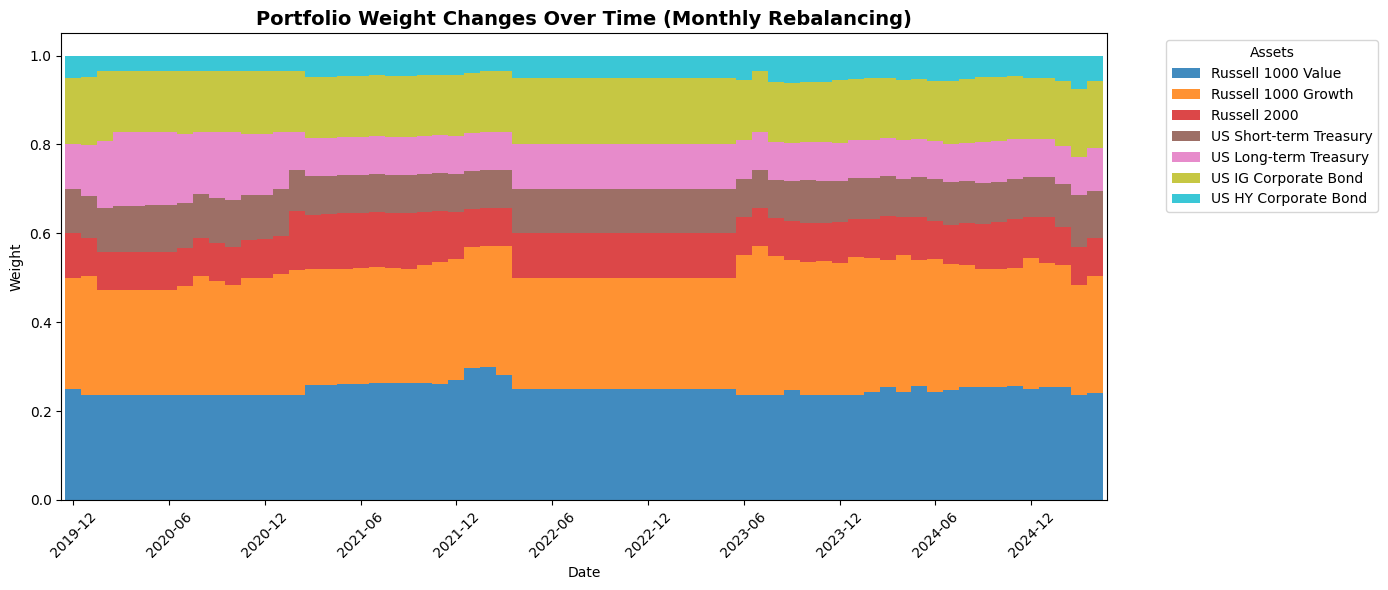

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt

# Calculate benchmark metrics
bench_returns = (R_test * w_bench).sum(axis=1)
bench_ann_return = bench_returns.mean() * 12
bench_ann_vol = bench_returns.std() * (12 ** 0.5)
bench_sharpe = bench_ann_return / (bench_ann_vol + 1e-12)
bench_max_dd = (1 + bench_returns).cumprod().div((1 + bench_returns).cumprod().cummax()).min() - 1

# Create a comparison table
metrics = {
    "Metric": ["Annualized Return", "Annualized Volatility", "Sharpe Ratio", "Max Drawdown"],
    "Monthly Rebalancing Portfolio": [
        summary_monthly["AnnReturn"],
        summary_monthly["AnnVol"],
        summary_monthly["Sharpe(0%)"],
        summary_monthly["MaxDD"],
    ],
    "Benchmark": [bench_ann_return, bench_ann_vol, bench_sharpe, bench_max_dd],
}
comparison_table = pd.DataFrame(metrics)

# Display the comparison table
#print(comparison_table)

# Visualize weight changes over time
plt.figure(figsize=(12, 6))
W_monthly.plot(kind="bar", stacked=True, width=1.0, figsize=(14, 6), colormap="tab10", alpha=0.85)
plt.title("Portfolio Weight Changes Over Time (Monthly Rebalancing)", fontsize=14, fontweight="bold")
plt.ylabel("Weight")
plt.xlabel("Date")
tick_positions = range(0, len(W_monthly.index), 6)  # Show every 6th tick
tick_labels = W_monthly.index[tick_positions].strftime('%Y-%m')  # Format as 'YYYY-MM'
plt.xticks(tick_positions, tick_labels, rotation=45)
plt.legend(title="Assets", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [44]:
print(pd.DataFrame({
        "steady":         np.array([ +0.01/12, +0.01/12, -0.01/12,  0.00/12, +0.01/12 ]),
        "mid expansion":  np.array([ +0.01/12, +0.01/12, -0.01/12,  0.00/12, +0.01/12 ]),
        "inflation":      np.array([ +0.01/12, -0.01/12, -0.03/12,  0.00/12, +0.01/12 ]),
        "crisis":         np.array([ -0.03/12, -0.03/12, +0.03/12, +0.04/12, -0.05/12 ]),
        "walking on ice": np.array([  0.00/12, +0.02/12, +0.02/12,  0.00/12, -0.01/12 ])
    }))

     steady  mid expansion  inflation    crisis  walking on ice
0  0.000833       0.000833   0.000833 -0.002500        0.000000
1  0.000833       0.000833  -0.000833 -0.002500        0.001667
2 -0.000833      -0.000833  -0.002500  0.002500        0.001667
3  0.000000       0.000000   0.000000  0.003333        0.000000
4  0.000833       0.000833   0.000833 -0.004167       -0.000833


In [53]:
# Calculate monthly returns for the portfolio and benchmark
port_monthly_returns = nav_monthly.pct_change().dropna()
bench_monthly_returns = bench_cum_returns.pct_change().dropna()

# Calculate Sharpe Ratio
port_ann_return = port_monthly_returns.mean() * 12
port_ann_vol = port_monthly_returns.std() * (12 ** 0.5)
sharpe_ratio = port_ann_return / (port_ann_vol + 1e-12)

# Calculate Information Ratio (IR)
excess_returns = port_monthly_returns - bench_monthly_returns
tracking_error = excess_returns.std() * (12 ** 0.5)
information_ratio = excess_returns.mean() * 12 / (tracking_error + 1e-12)

# Calculate Cumulative Returns
cum_returns_portfolio = nav_monthly.iloc[-1] - 1  # Final NAV - 1
cum_returns_benchmark = bench_cum_returns.iloc[-1] - 1  # Final benchmark value - 1

# Print results
print(f"Sharpe Ratio: {sharpe_ratio:.6f}")
print(f"Information Ratio: {information_ratio:.6f}")
print(f"Cumulative Returns (Portfolio): {cum_returns_portfolio:.6f}")
print(f"Cumulative Returns (Benchmark): {cum_returns_benchmark:.6f}")

Sharpe Ratio: 0.551398
Information Ratio: 0.746880
Cumulative Returns (Portfolio): 0.425659
Cumulative Returns (Benchmark): 0.373584


In [54]:
# Calculate monthly returns for the benchmark
bench_monthly_returns = bench_cum_returns.pct_change().dropna()

# Calculate annualized return
bench_ann_return = bench_monthly_returns.mean() * 12

# Calculate annualized volatility
bench_ann_vol = bench_monthly_returns.std() * (12 ** 0.5)

# Calculate Sharpe ratio (assuming risk-free rate is 0)
bench_sharpe = bench_ann_return / (bench_ann_vol + 1e-12)

print(f"Sharpe Ratio of Benchmark: {bench_sharpe:.6f}")

Sharpe Ratio of Benchmark: 0.489692


In [55]:
def calculate_max_drawdown(series):
    """
    Calculate the maximum drawdown of a time series.
    """
    cumulative_max = series.cummax()
    drawdown = (series / cumulative_max) - 1
    max_drawdown = drawdown.min()
    return max_drawdown

# Calculate max drawdowns
max_drawdown_nav_monthly = calculate_max_drawdown(nav_monthly)
max_drawdown_bench_cum_returns = calculate_max_drawdown(bench_cum_returns)

print(f"Max Drawdown (NAV Monthly): {max_drawdown_nav_monthly:.6f}")
print(f"Max Drawdown (Benchmark Cumulative Returns): {max_drawdown_bench_cum_returns:.6f}")

Max Drawdown (NAV Monthly): -0.220819
Max Drawdown (Benchmark Cumulative Returns): -0.222792
